In [1]:
import json
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import copy

import dijkstra as dijk
import stacked_graph as sg
import testing as test
import graph_visualization as gv

# 1

In [2]:

# read_json_path = '/home/rjtomich/photonic_compiler/model_to_graph/gpt2_graph.json'
# # read_json_path = '/home/rjtomich/photonic_compiler/model_to_graph/bert-base-uncased_graph.json'
# # read_json_path = '/home/rjtomich/photonic_compiler/Pytorch-LeNet/simple_LeNet_graph.json'
# # read_json_path = '/home/rjtomich/photonic_compiler/Pytorch-LeNet/simple_LeNet_graph_NoFusion.json'
# with open(read_json_path)  as json_file:
#     raw_json = json.load(json_file) # returns json file as dict

# graph = sg.StackedGraph(raw_json=raw_json)

# subgraphs = list(dijk.graph_partition(graph))
# dijk.select_nodes(graph, subgraphs)


In [3]:
# groups = list(graph.get_node_groups(asap = False))
# print(test.group_validate(graph, groups))
# for group in groups:
#     print(group)


In [4]:
# n_graphs = len(groups)
# n_cols = 6  # Number of columns for the grid
# n_rows = (n_graphs + n_cols - 1) // n_cols  # Calculate the number of rows needed

# fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))
# axes = axes.flatten()  # Flatten the array of axes


# for i in range(len(groups)):
#     if i >= 0:
#         test_group = groups[i]

#         start_stack = sg.StackedNode(0, [], [[]], [[]], opp='start', func_stack=['start'], cost_stack=[0])
#         first_stack = copy.deepcopy(graph.stack_list[graph.id_to_idx[test_group[0]]])
#         first_stack.parents = [0]

#         subgraph_stack_list = [start_stack, first_stack]
#         for stack_id in test_group[1:]:
#             stack = graph.stack_list[graph.id_to_idx[stack_id]]
#             new_node = copy.deepcopy(stack)
#             new_node.parents = set(new_node.parents) - graph.in_nodes
#             subgraph_stack_list.append(new_node)


#         new_graph = sg.StackedGraph(stack_list=subgraph_stack_list)
#         # gv.adj_to_graph(new_graph.adj_matrix, save=False, layout = 'spectral')
#         # gv.adj_to_graph(new_graph, save=False, layout = 'kk', title = f'Subgraph {i}')
#         gv.adj_to_graph(new_graph, ax=axes[i], layout='kk', title=f'Subgraph {i+1}')


# for j in range(i + 1, len(axes)):
#     fig.delaxes(axes[j])


# plt.tight_layout()
# plt.show()


# 2 Graph Visualization

In [5]:
subgraph_to_plot = 3


read_json_path = '/home/rjtomich/photonic_compiler/model_to_graph/gpt2_graph.json'
# read_json_path = '/home/rjtomich/photonic_compiler/model_to_graph/bert-base-uncased_graph.json'
# read_json_path = '/home/rjtomich/photonic_compiler/Pytorch-LeNet/simple_LeNet_graph.json'
# read_json_path = '/home/rjtomich/photonic_compiler/Pytorch-LeNet/simple_LeNet_graph_NoFusion.json'
with open(read_json_path)  as json_file:
    raw_json = json.load(json_file) # returns json file as dict

graph = sg.StackGraph(raw_json=raw_json)
stacked_subgraphs = list(dijk.graph_partition(graph))
flat_subgraphs = dijk.select_nodes(stacked_subgraphs)
expanded_flat_subgraphs = dijk.expand_nodes(flat_subgraphs)
print(len(expanded_flat_subgraphs))

stacked_subgraphs = list(dijk.graph_partition(graph))
flat_subgraphs = dijk.select_nodes(stacked_subgraphs)
expanded_flat_subgraphs = dijk.expand_nodes(flat_subgraphs)


... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Subgraphs Made ...
... Nodes selected ...
... Nodes Expanded ...
28
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made .

In [6]:
def draw_subgraphs(subgraph, sub = False):
    fig, ax = plt.subplots(figsize=(10, 10))

    gv.adj_to_graph(subgraph, ax=ax, layout='kk', title=f'Subgraph')
    # plt.tight_layout()
    plt.show()

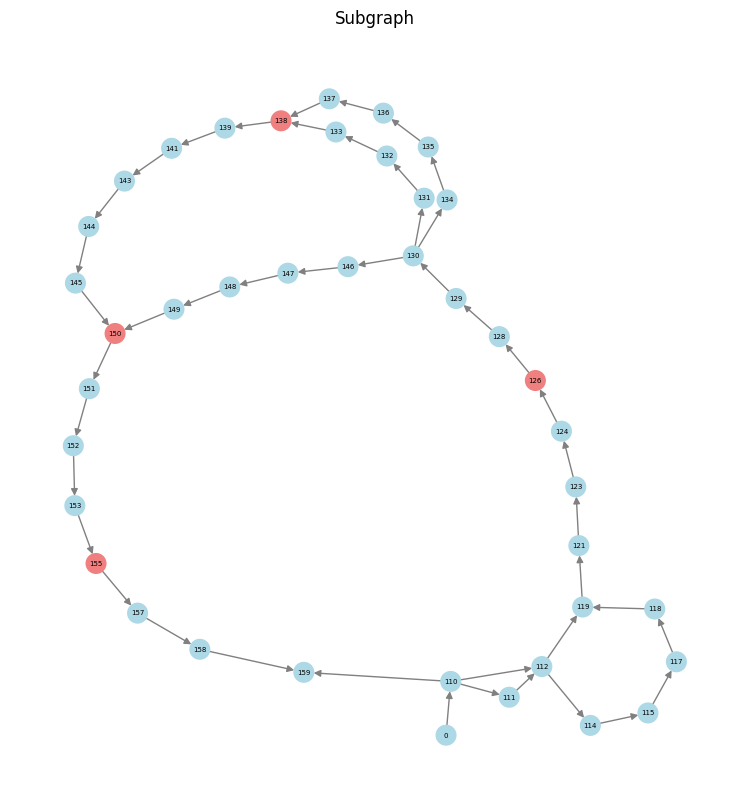

In [7]:
draw_subgraphs(flat_subgraphs[subgraph_to_plot])


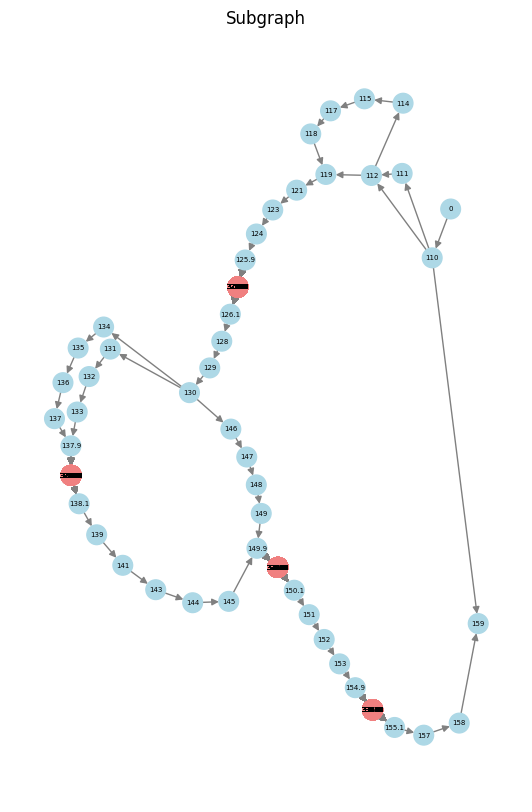

In [8]:
# draw_subgraphs(graph)
# draw_subgraphs(graph)
draw_subgraphs(expanded_flat_subgraphs[subgraph_to_plot])
# draw_subgraphs(graph, sub='all')

# 3 Timeline Visualization

... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Graph Made ...
... Subgraphs Made ...


... Nodes selected ...
... Nodes Expanded ...
...     ... Subgraph Scheduled ...
...     ... Subgraph Scheduled ...
...     ... Subgraph Scheduled ...
...     ... Subgraph Scheduled ...
...     ... Subgraph Scheduled ...
...     ... Subgraph Scheduled ...
...     ... Subgraph Scheduled ...
...     ... Subgraph Scheduled ...
...     ... Subgraph Scheduled ...
...     ... Subgraph Scheduled ...
...     ... Subgraph Scheduled ...
...     ... Subgraph Scheduled ...
...     ... Subgraph Scheduled ...
...     ... Subgraph Scheduled ...
...     ... Subgraph Scheduled ...
...     ... Subgraph Scheduled ...
...     ... Subgraph Scheduled ...
...     ... Subgraph Scheduled ...
...     ... Subgraph Scheduled ...
...     ... Subgraph Scheduled ...
...     ... Subgraph Scheduled ...
...     ... Subgraph Scheduled ...
...     ... Subgraph Scheduled ...
...     ... Subgraph Scheduled ...
...     ... Subgraph Scheduled ...
...     ... Subgraph Scheduled ...
...     ... Subgraph Scheduled ...
...     .

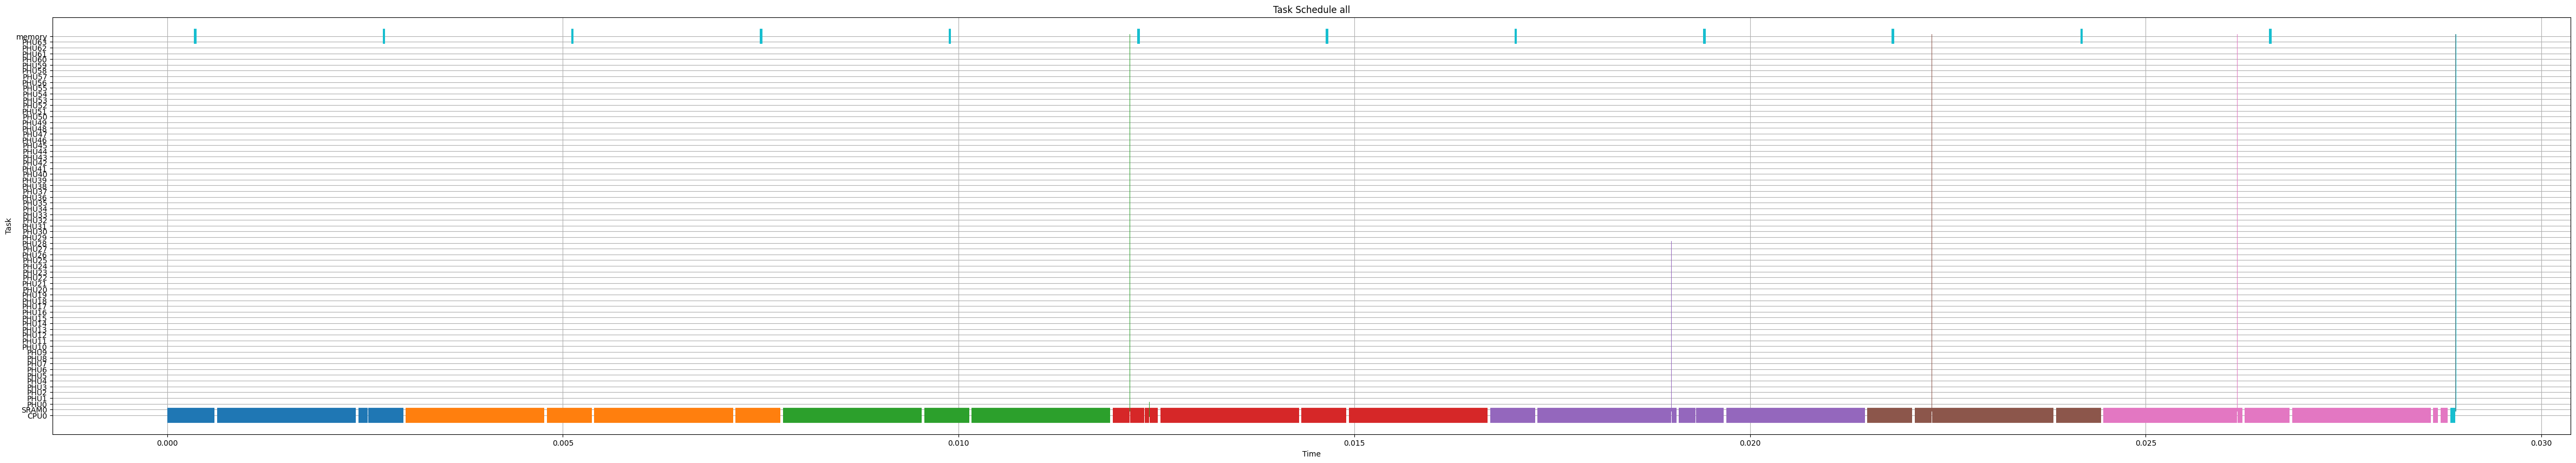

0
1.3000000000000003e-07 - 0.0005994023999999998
(30817, 4)


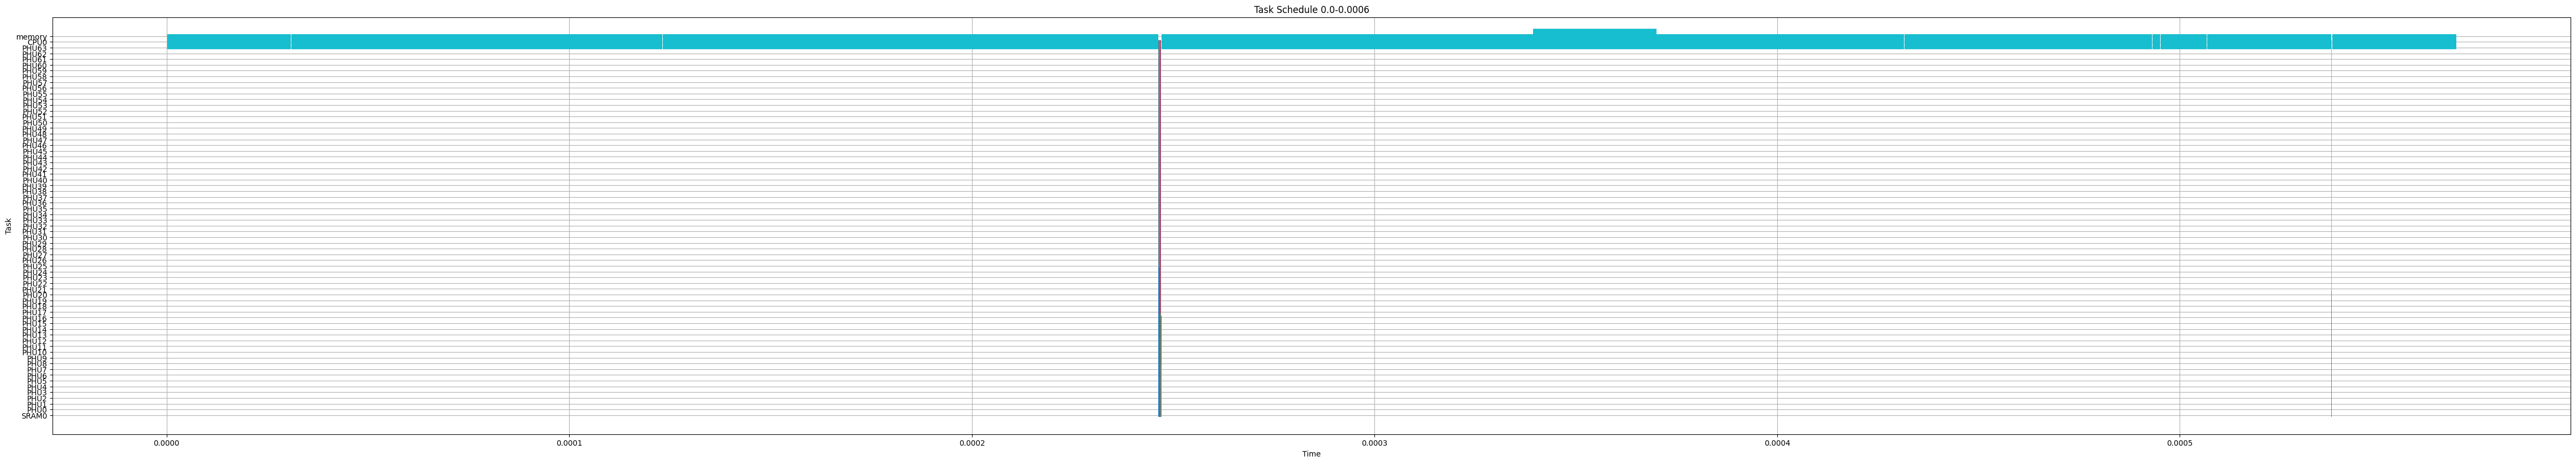

1
0.0005994023999999998 - 0.002383722
(30817, 4)


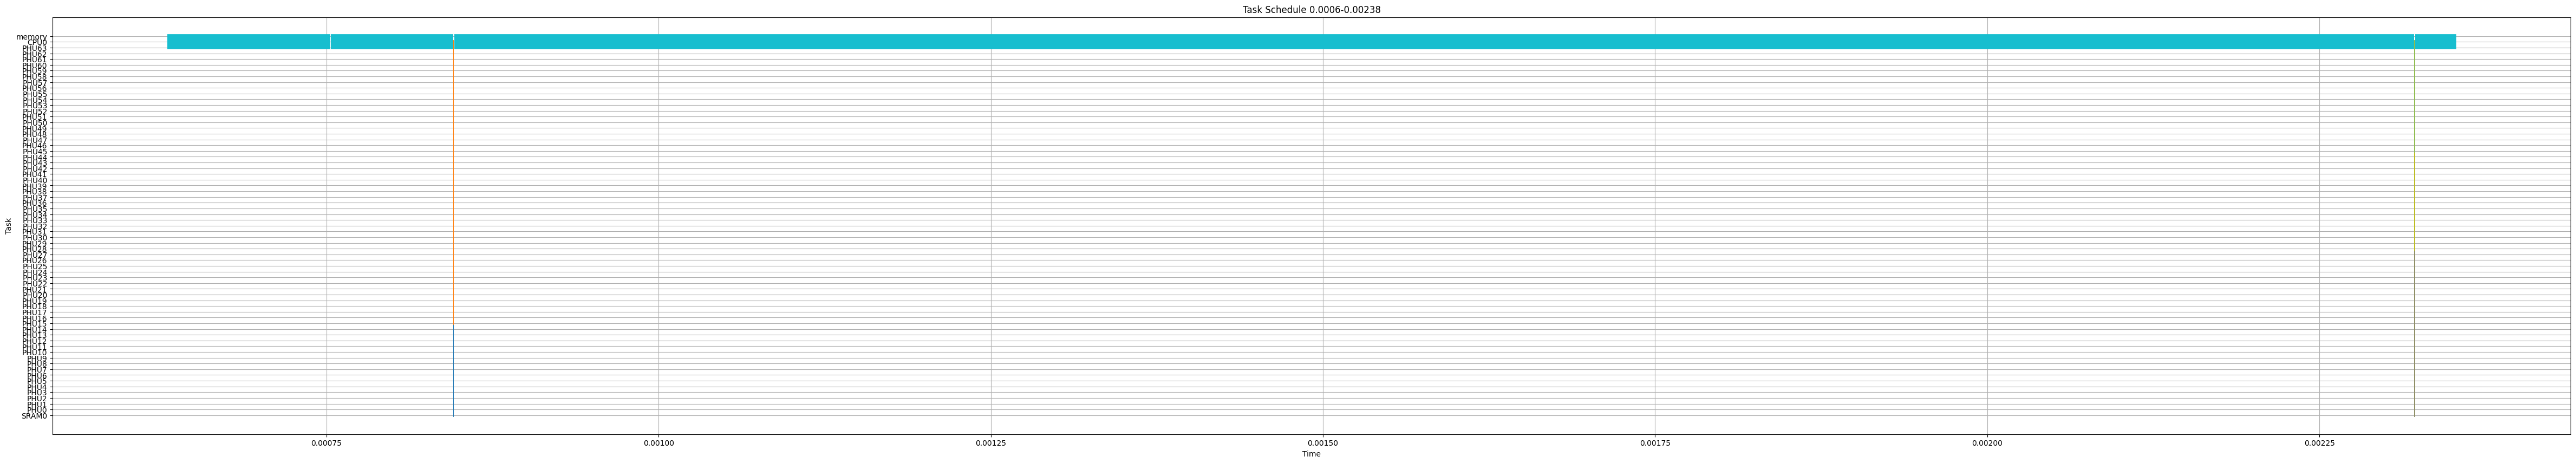

2
0.002383722 - 0.0029829343999999993
(30817, 4)


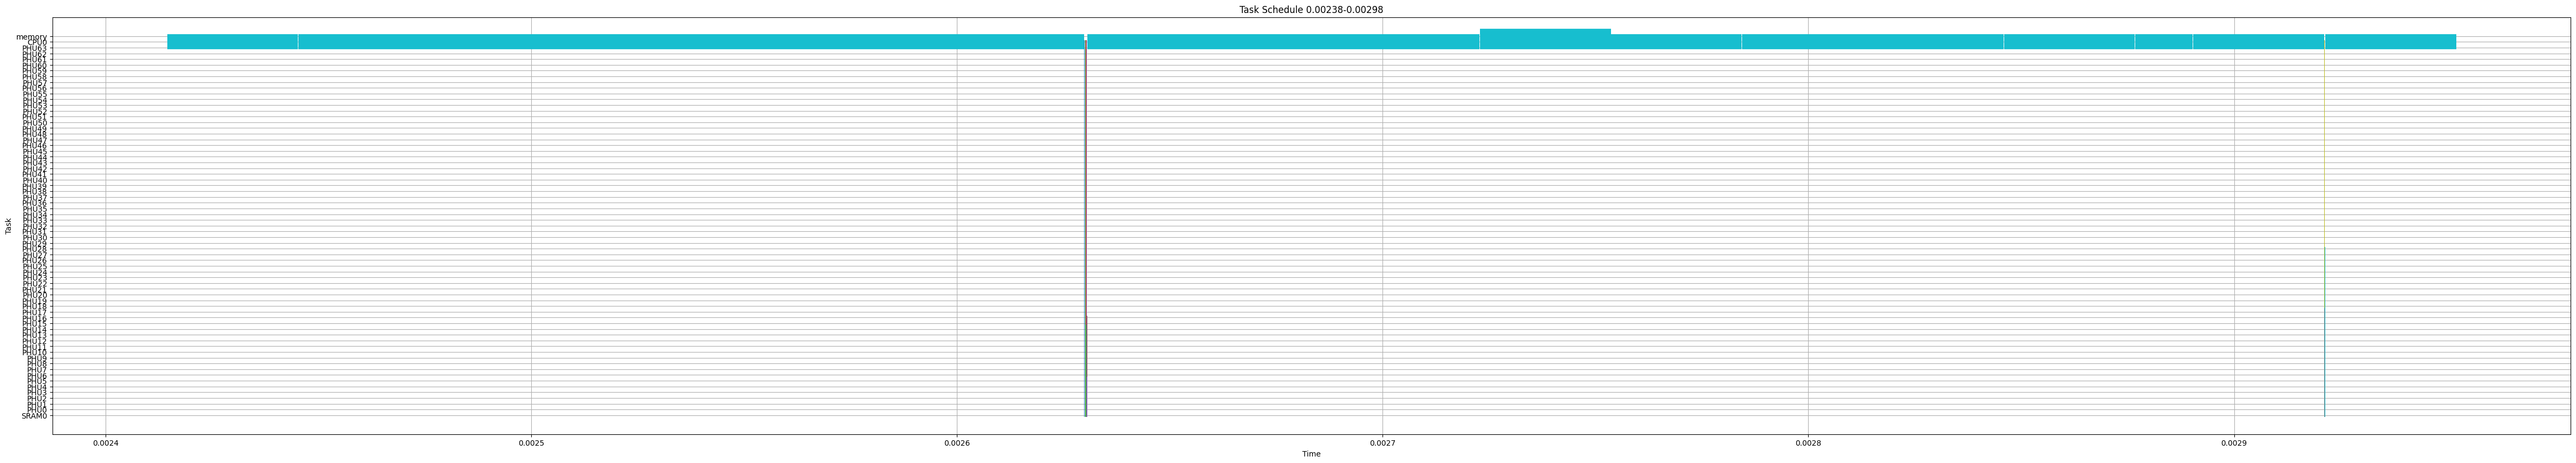

3
0.0029829343999999993 - 0.004767253999999998
(30817, 4)


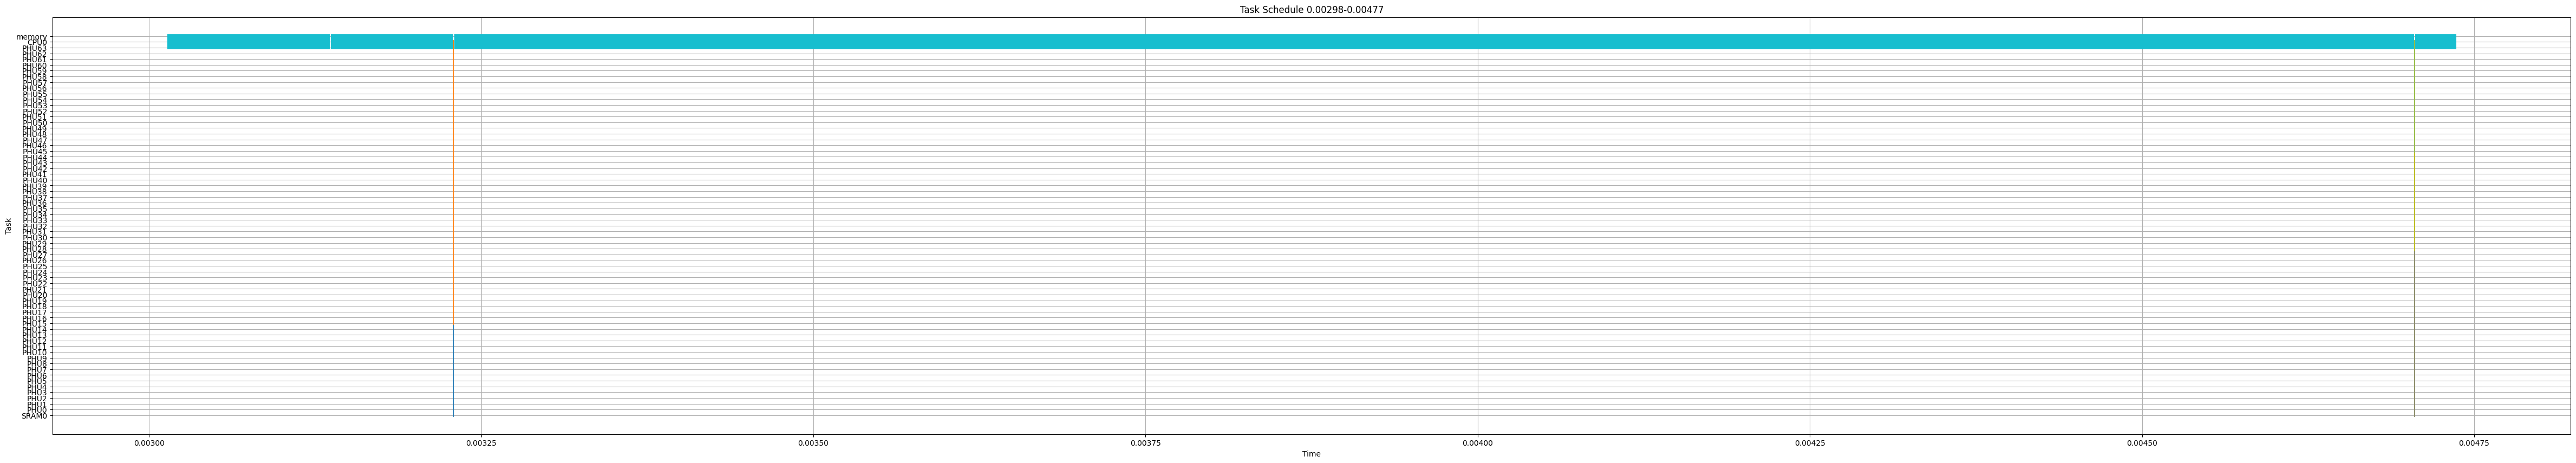

4
0.004767253999999998 - 0.00536646639999999
(30817, 4)


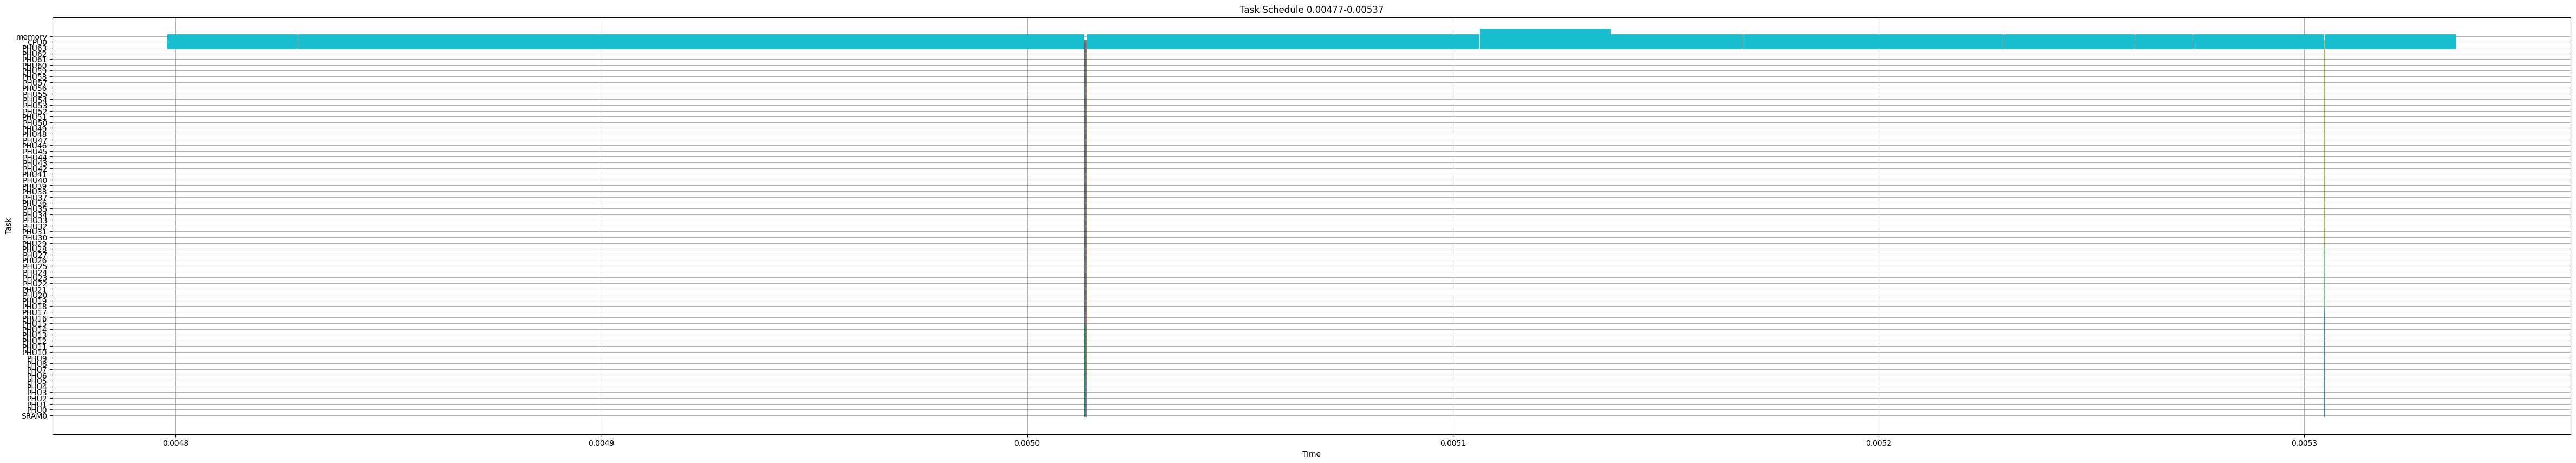

5
0.00536646639999999 - 0.007150785999999983
(30817, 4)


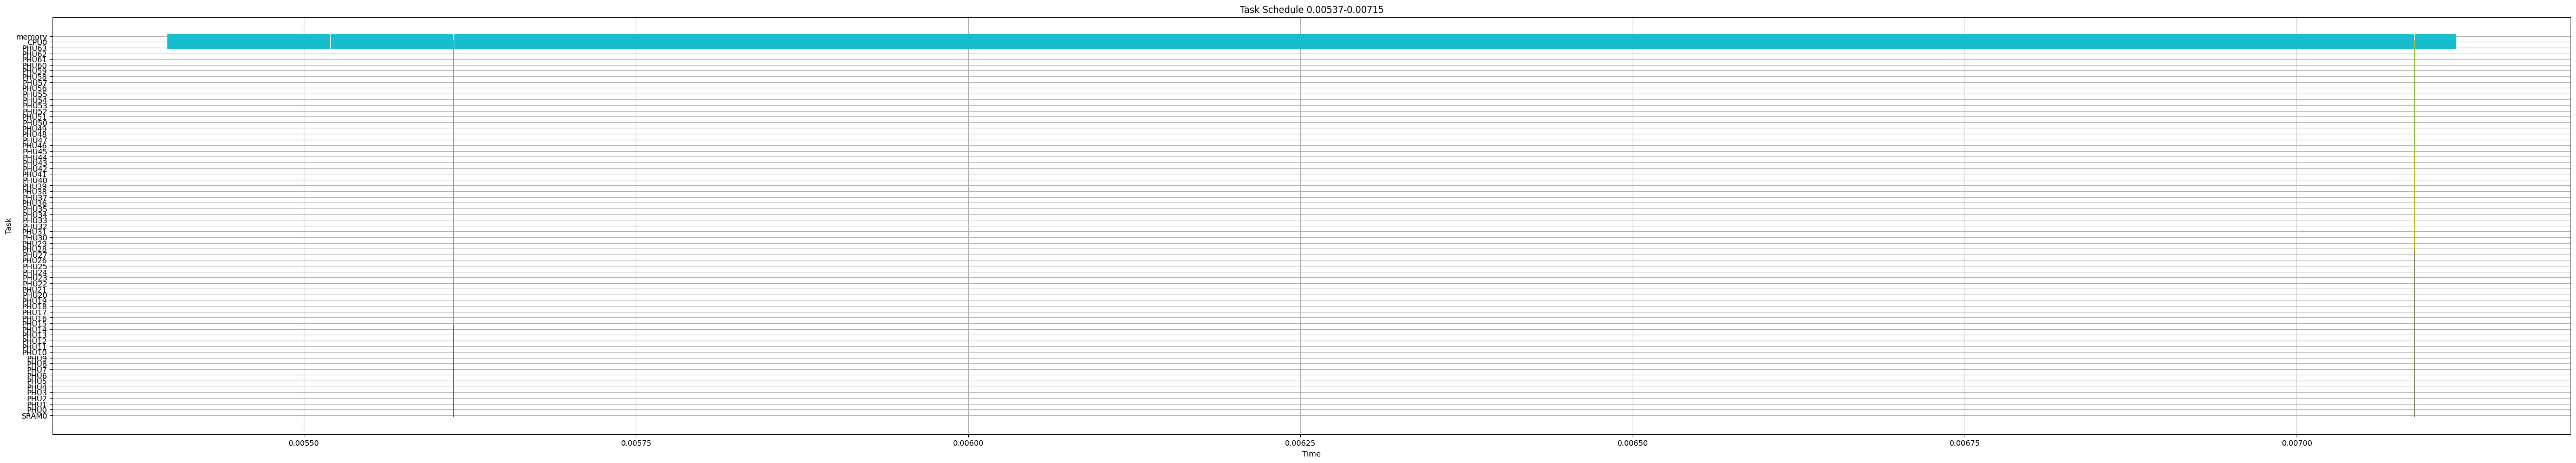

6
0.007150785999999983 - 0.007749998399999975
(30817, 4)


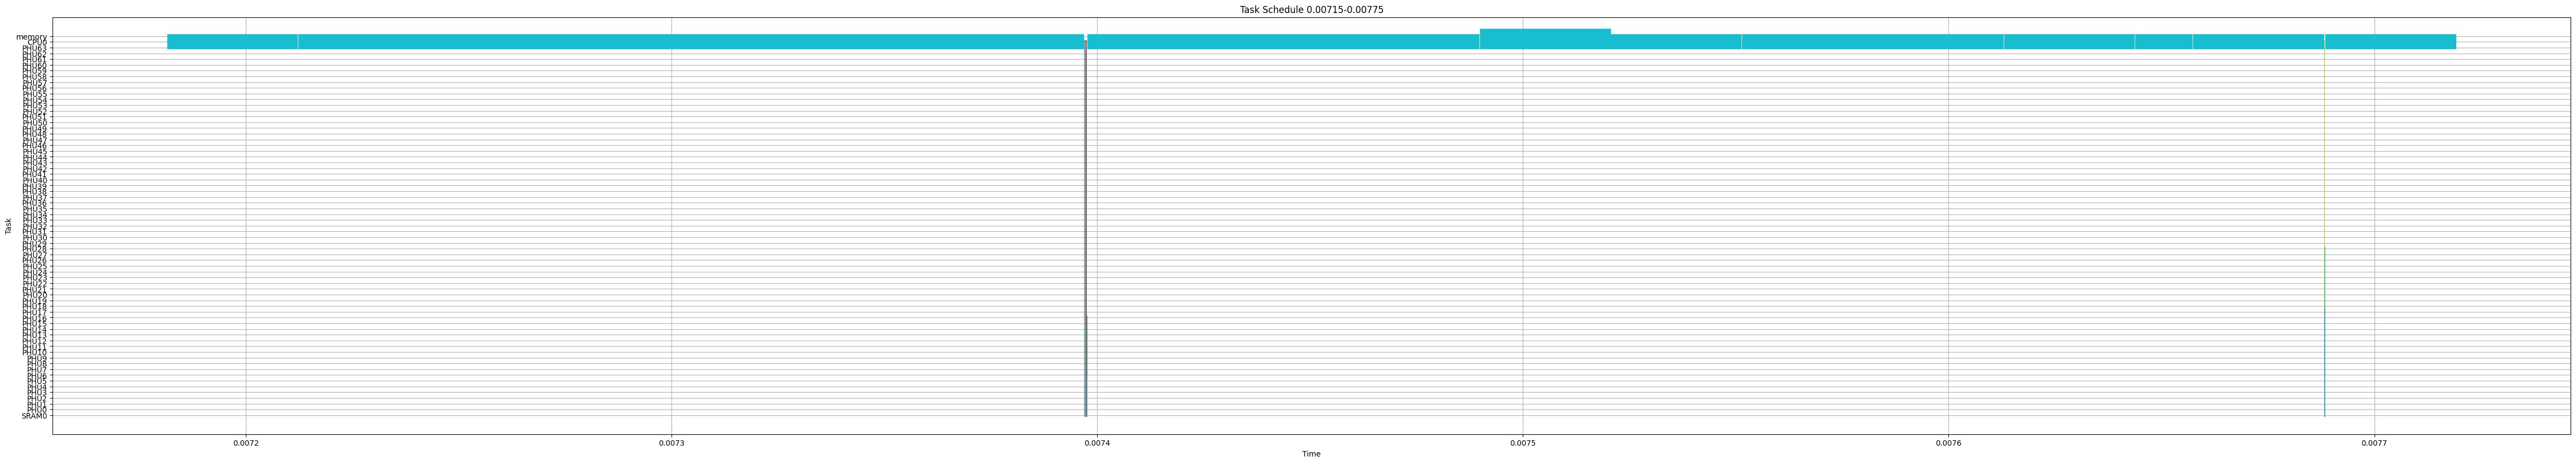

7
0.007749998399999975 - 0.009534317999999977
(30817, 4)


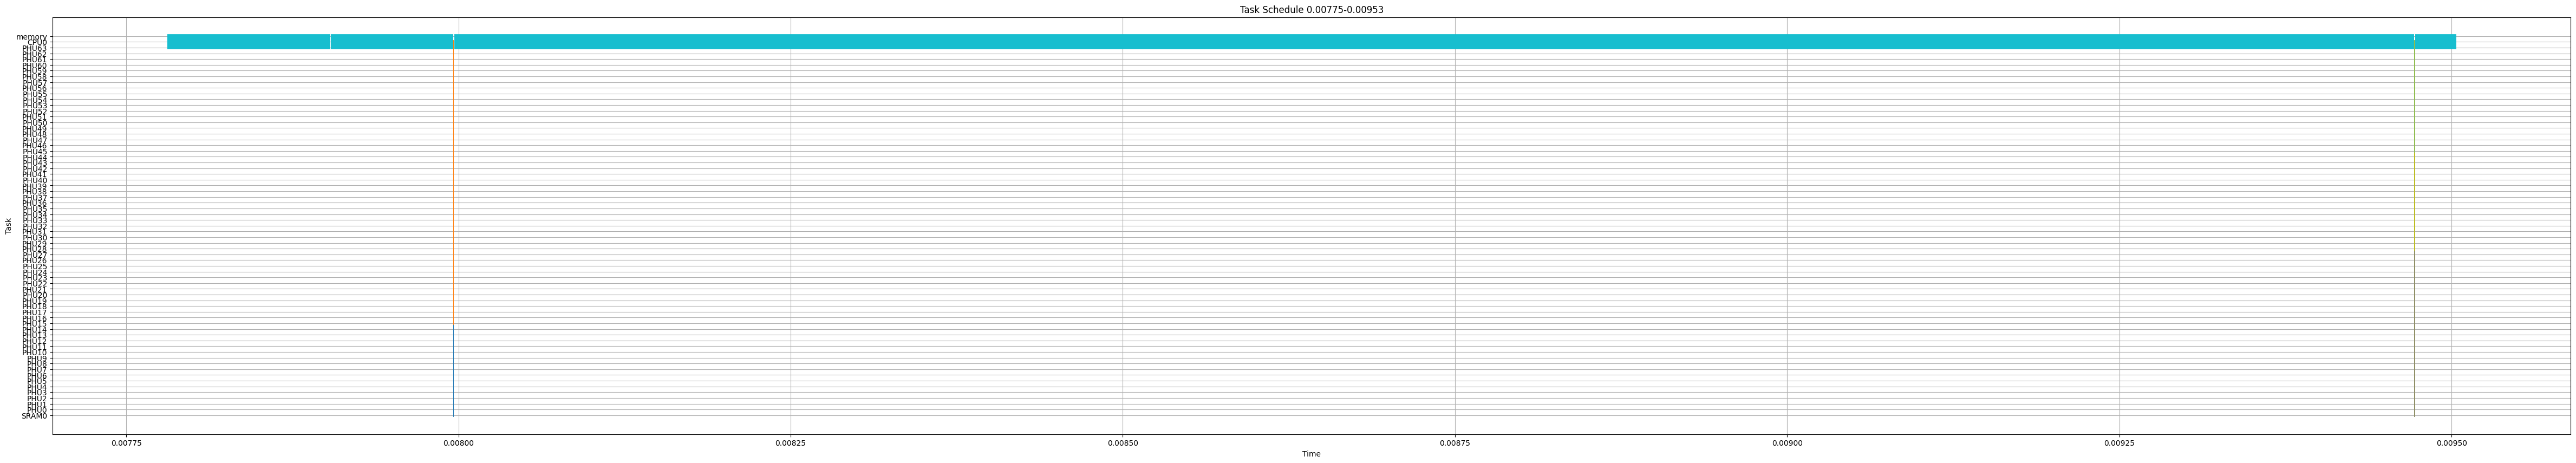

8
0.009534317999999977 - 0.01013353039999997
(30817, 4)


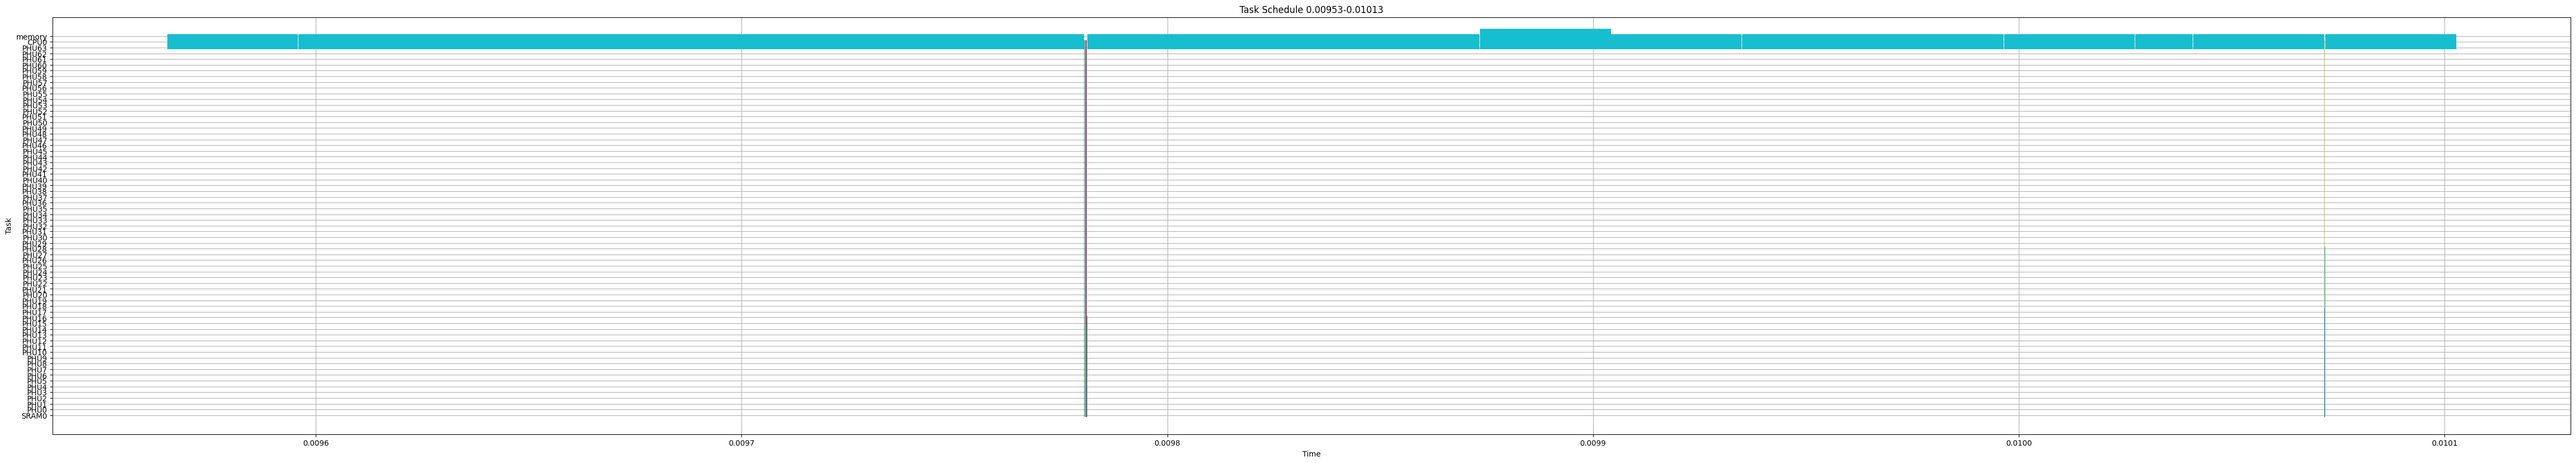

9
0.01013353039999997 - 0.011917849999999971
(30817, 4)


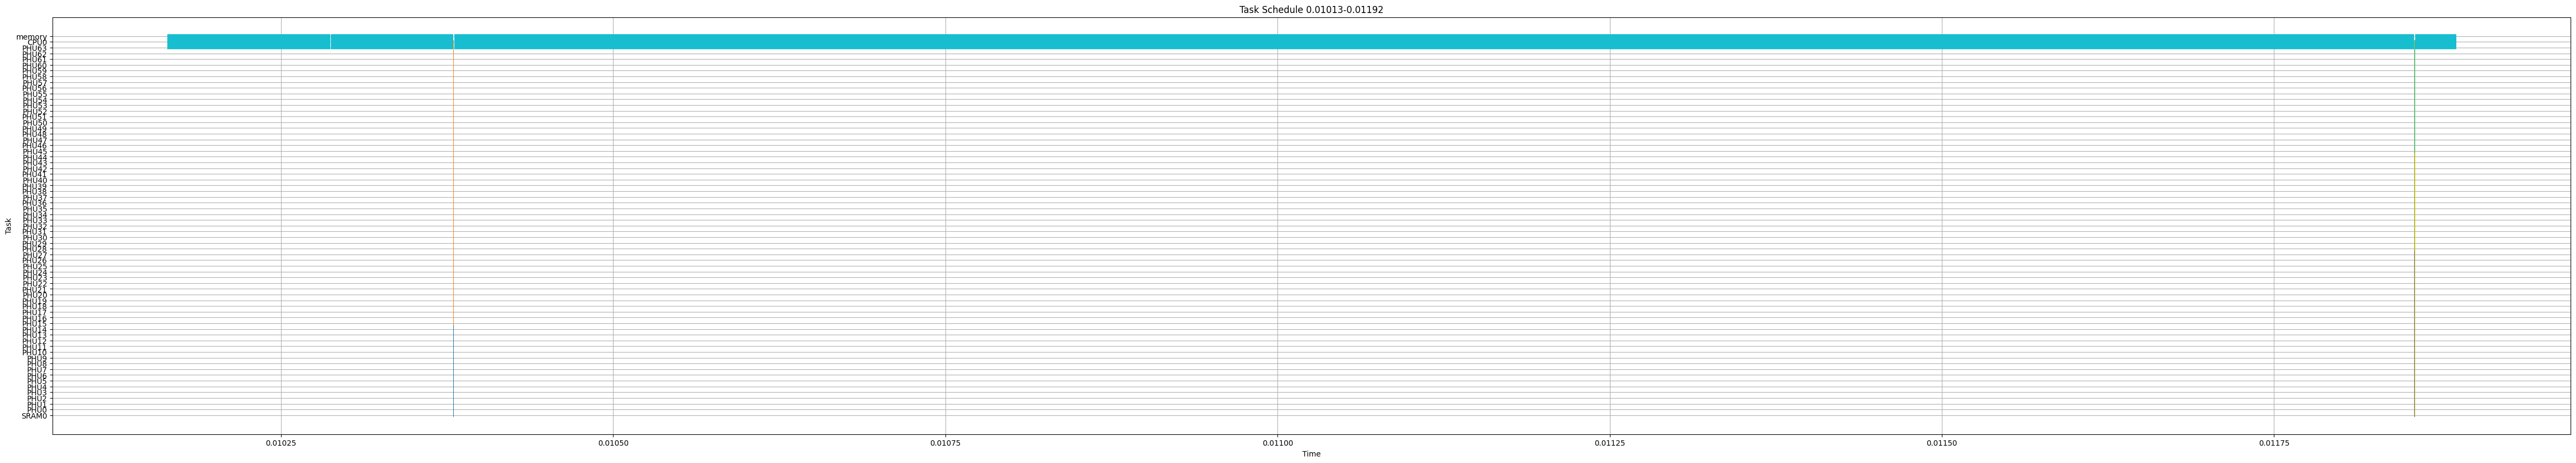

10
0.011917849999999971 - 0.012517062399999964
(30817, 4)


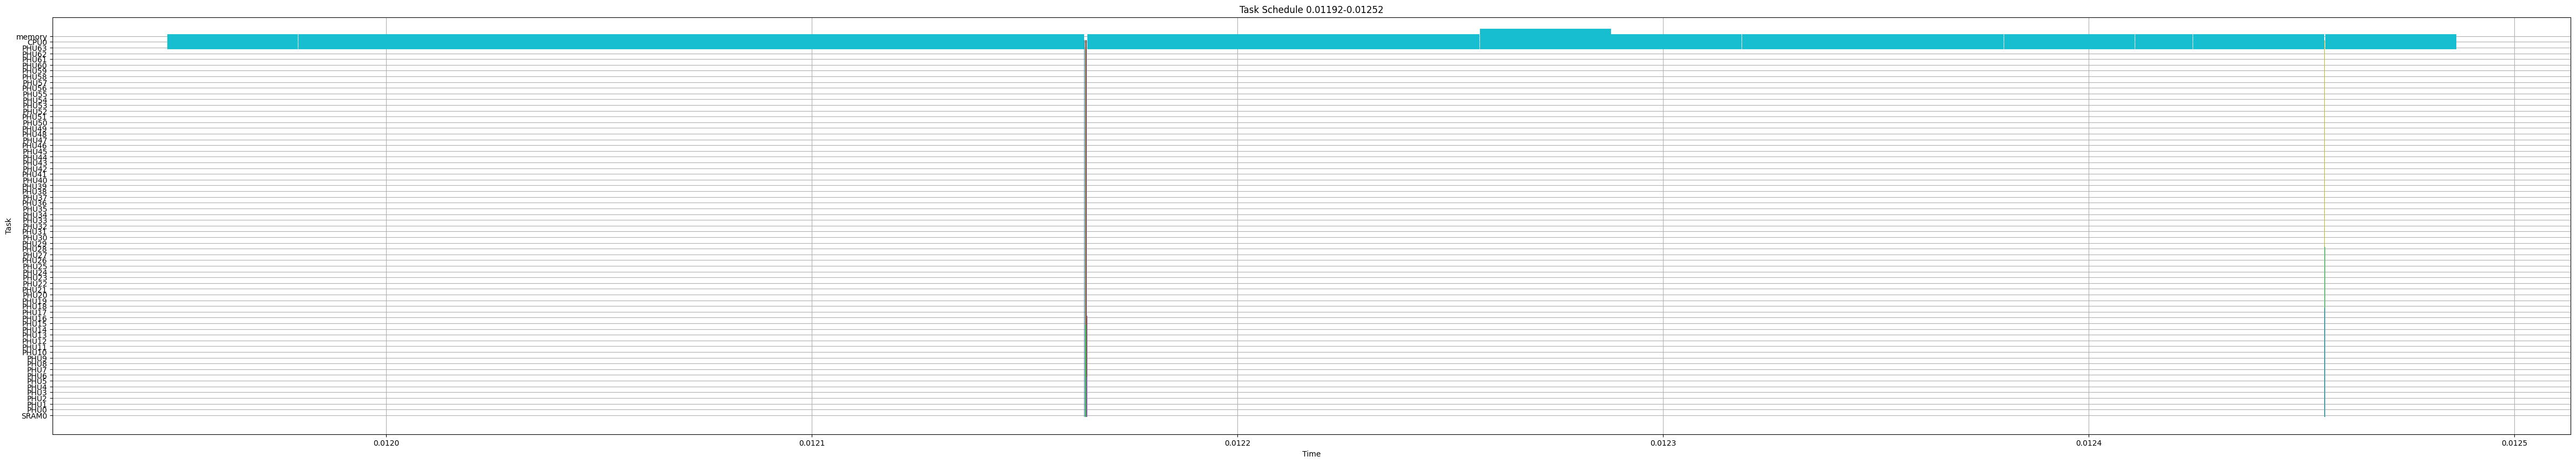

11
0.012517062399999964 - 0.014301381999999965
(30817, 4)


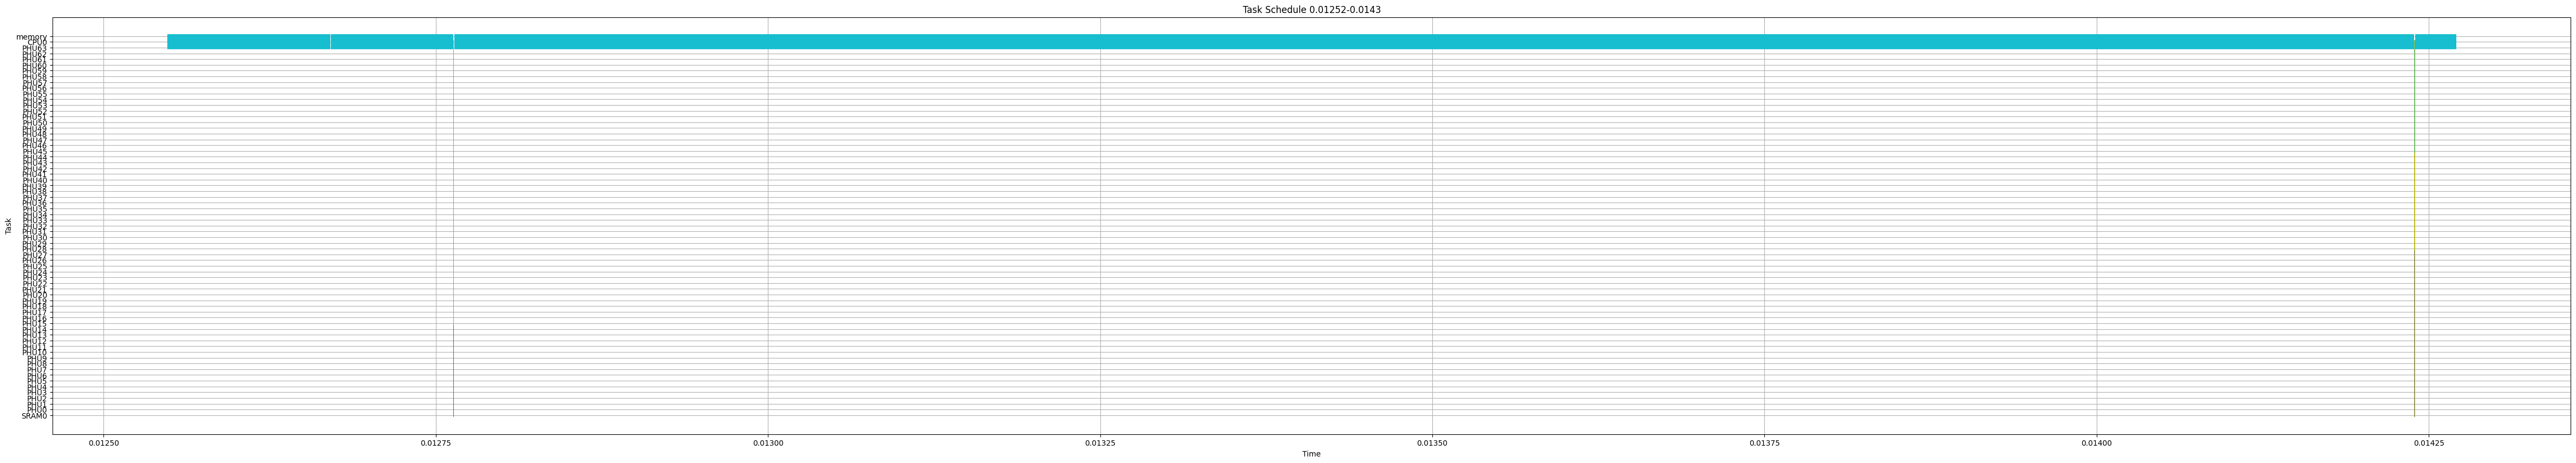

12
0.014301381999999965 - 0.014900594399999958
(30817, 4)


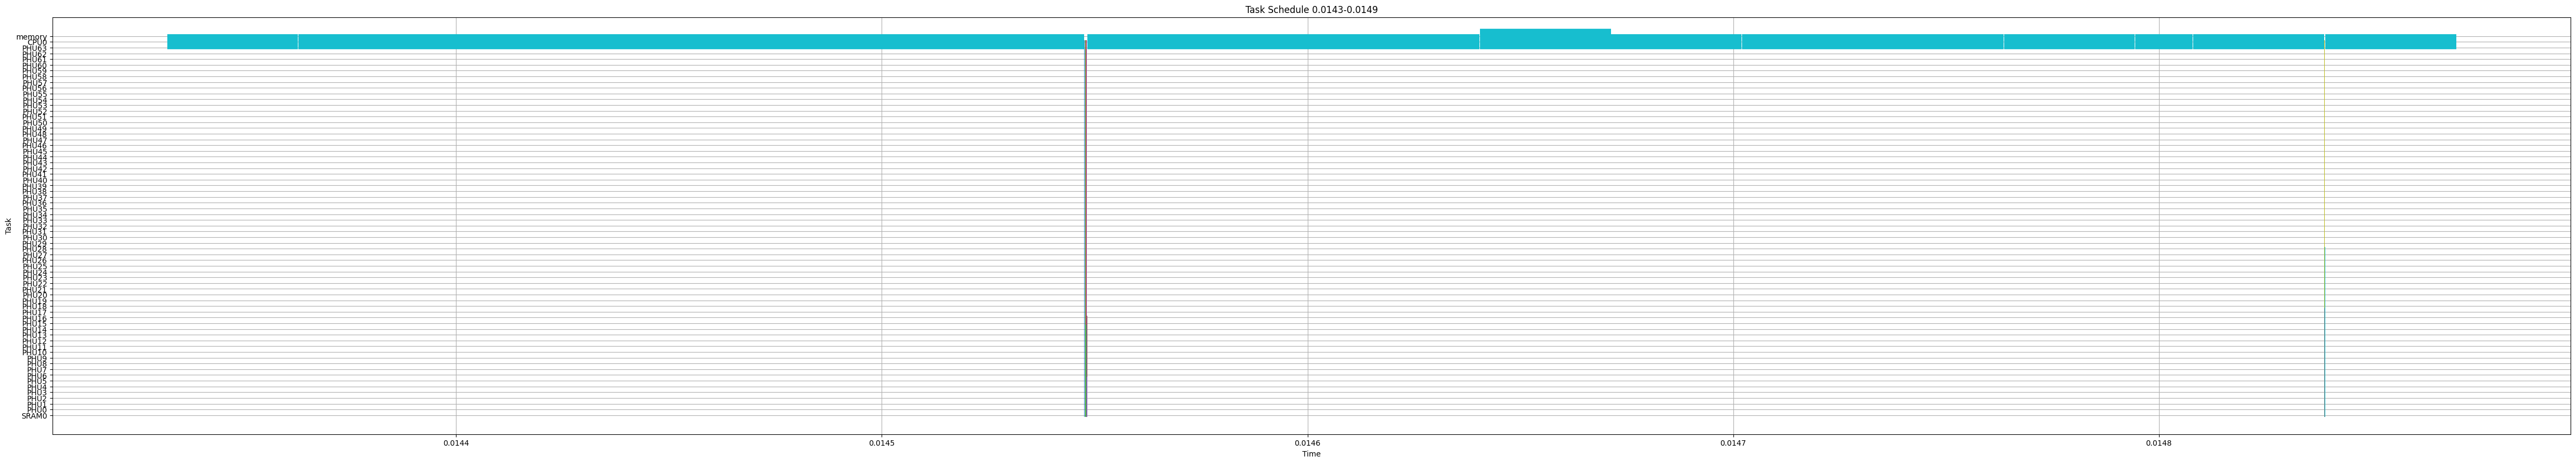

13
0.014900594399999958 - 0.01668491399999995
(30817, 4)


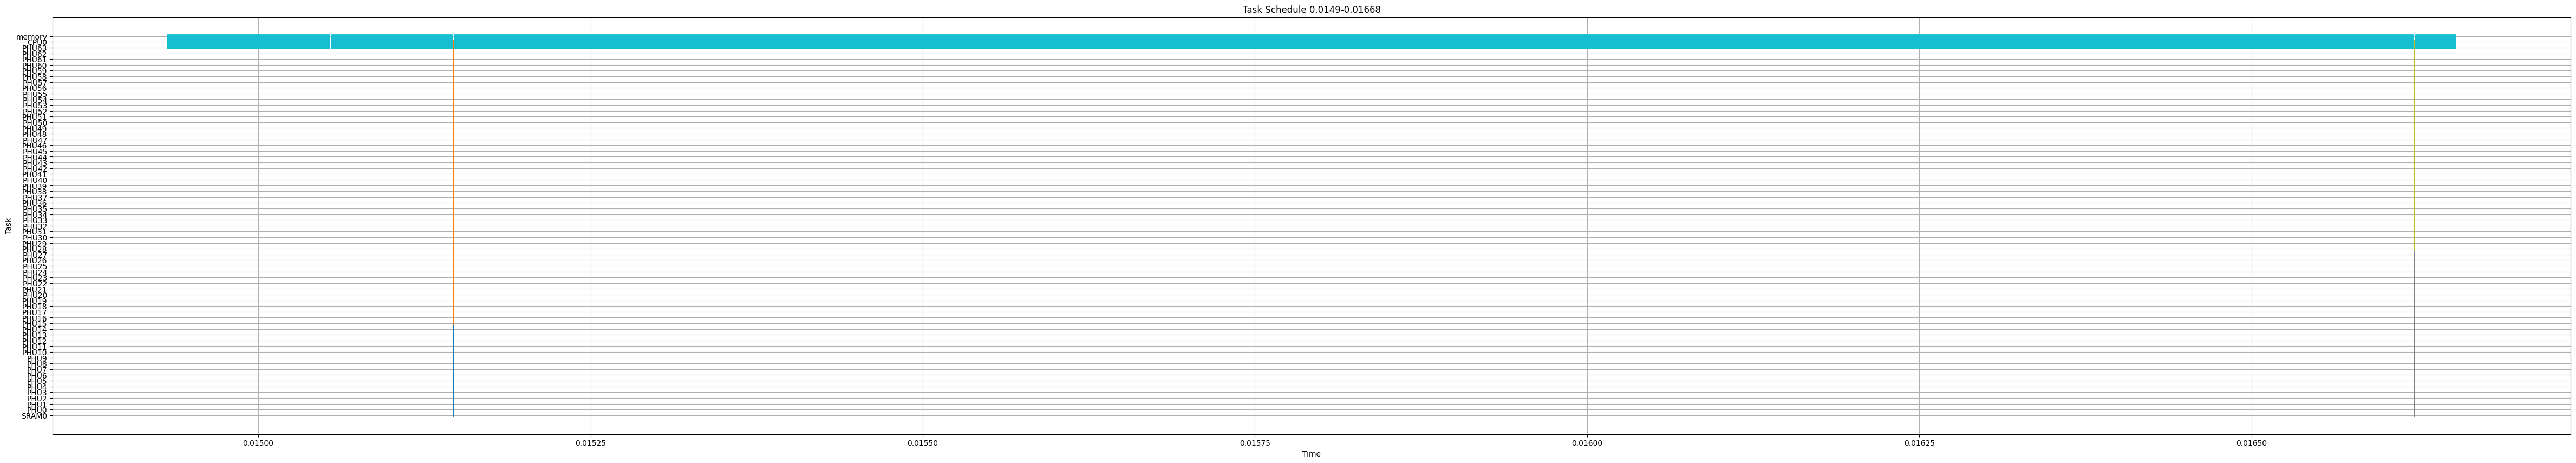

14
0.01668491399999995 - 0.01728412639999998
(30817, 4)


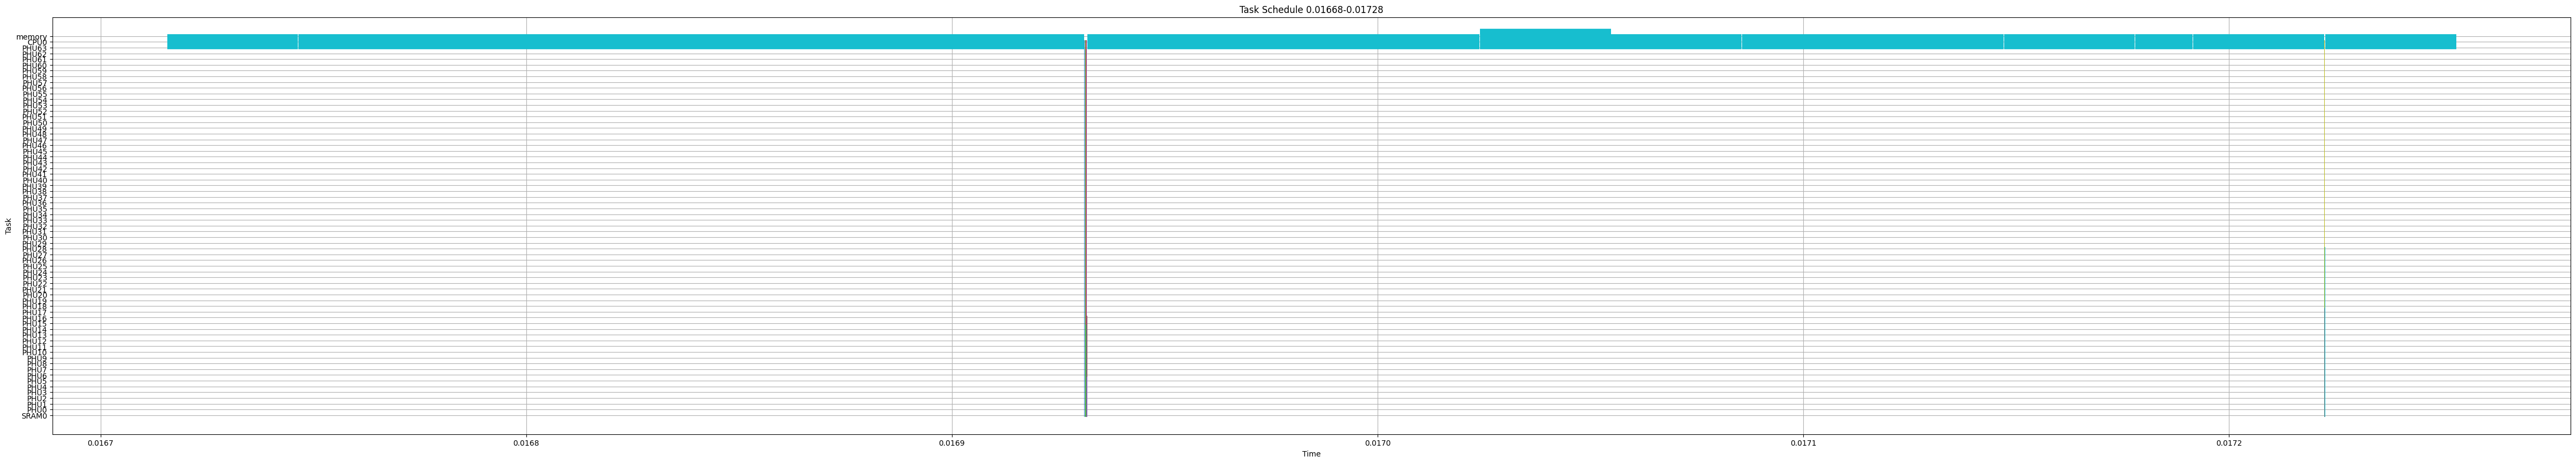

15
0.01728412639999998 - 0.019068445999999985
(30817, 4)


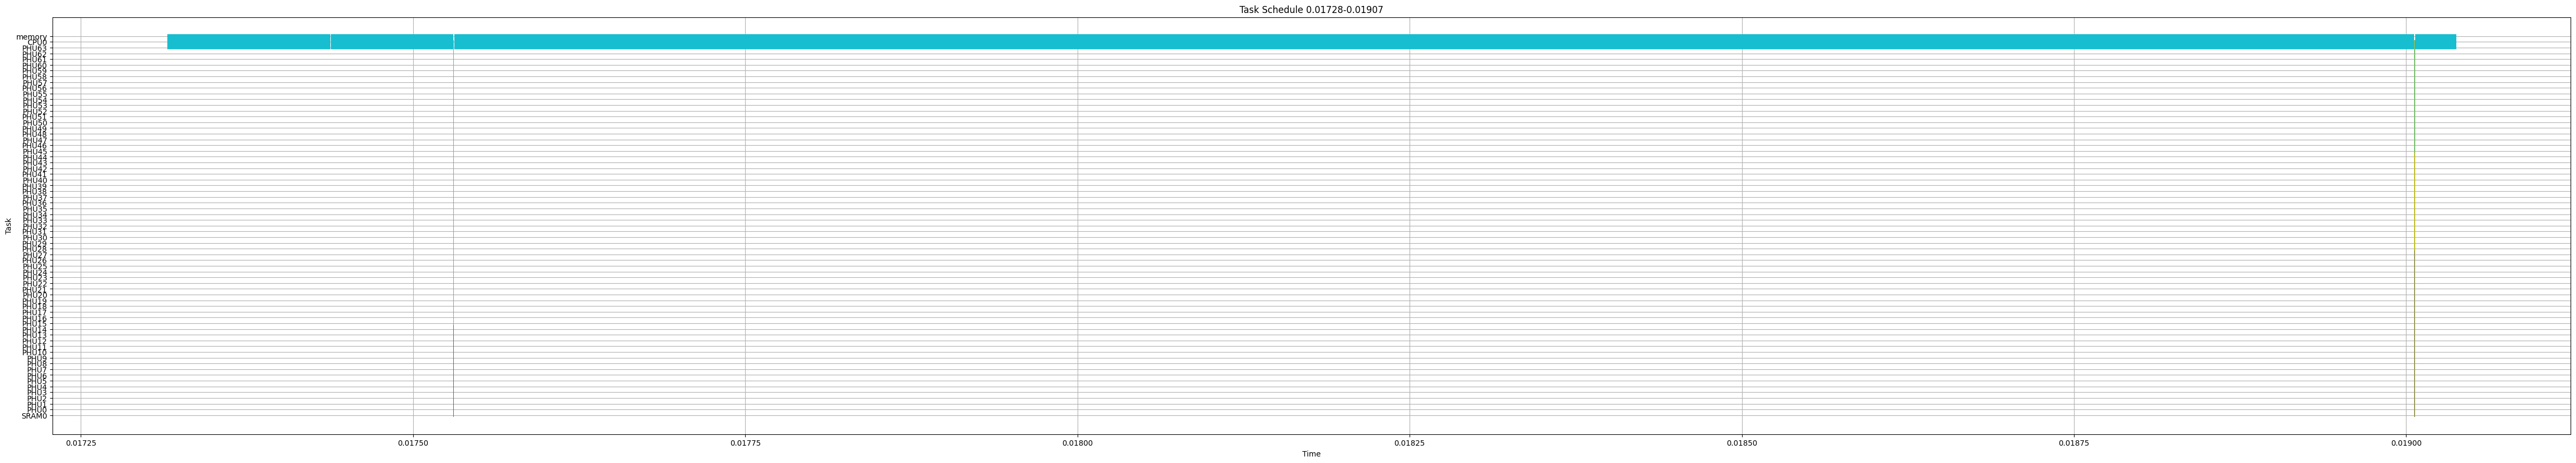

16
0.019068445999999985 - 0.019667658400000017
(30817, 4)


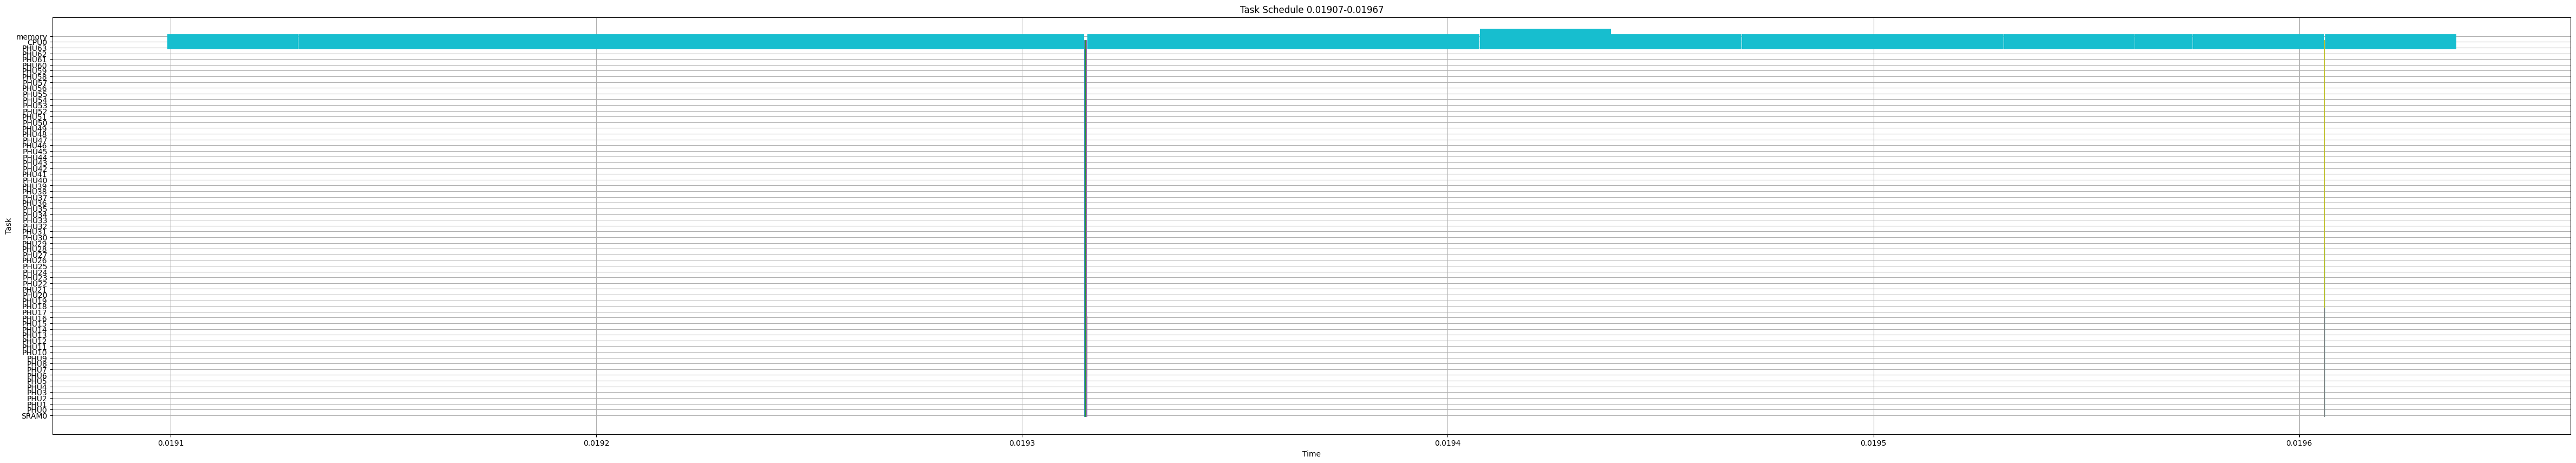

17
0.019667658400000017 - 0.02145197800000002
(30817, 4)


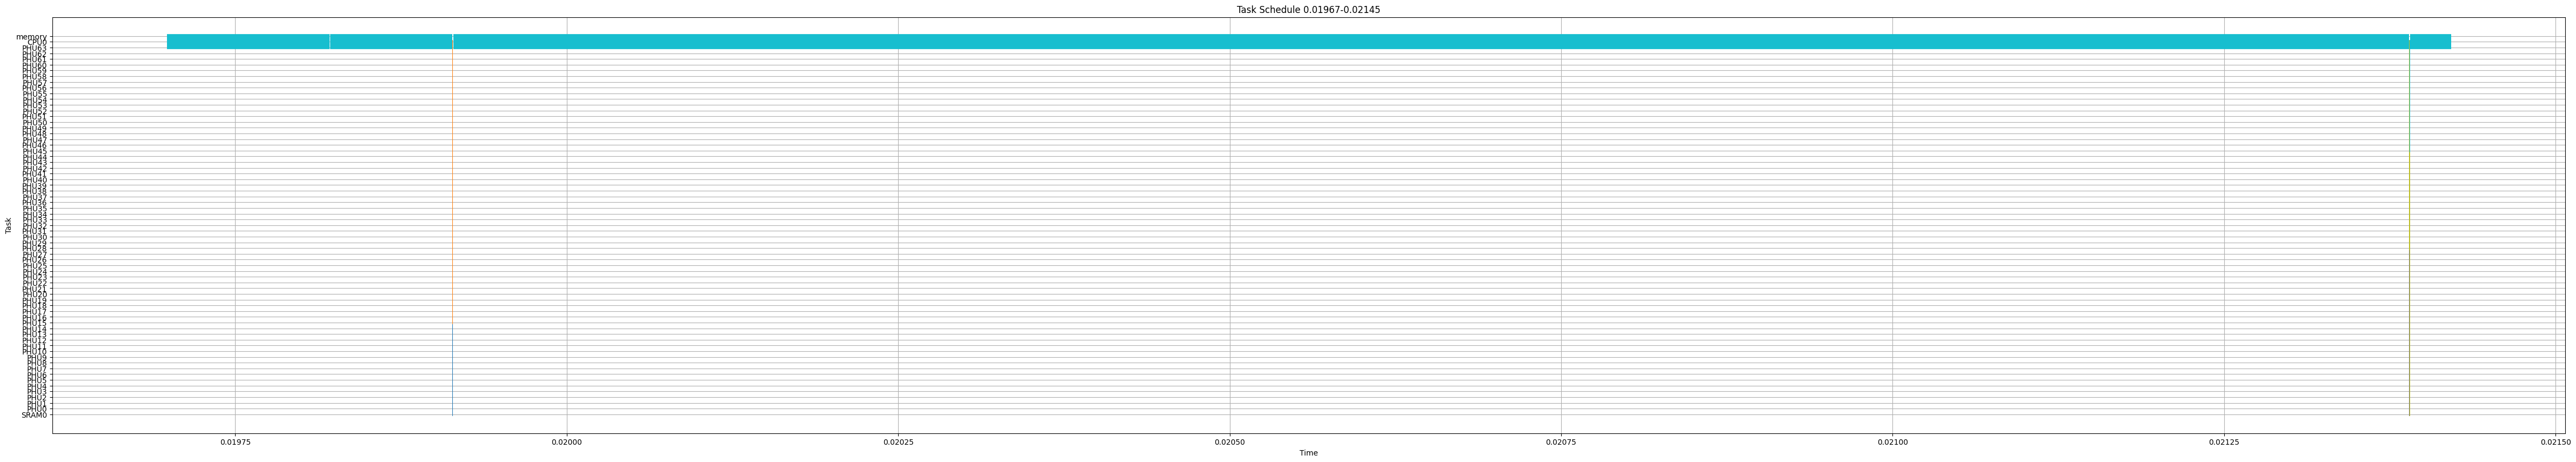

18
0.02145197800000002 - 0.022051190400000052
(30817, 4)


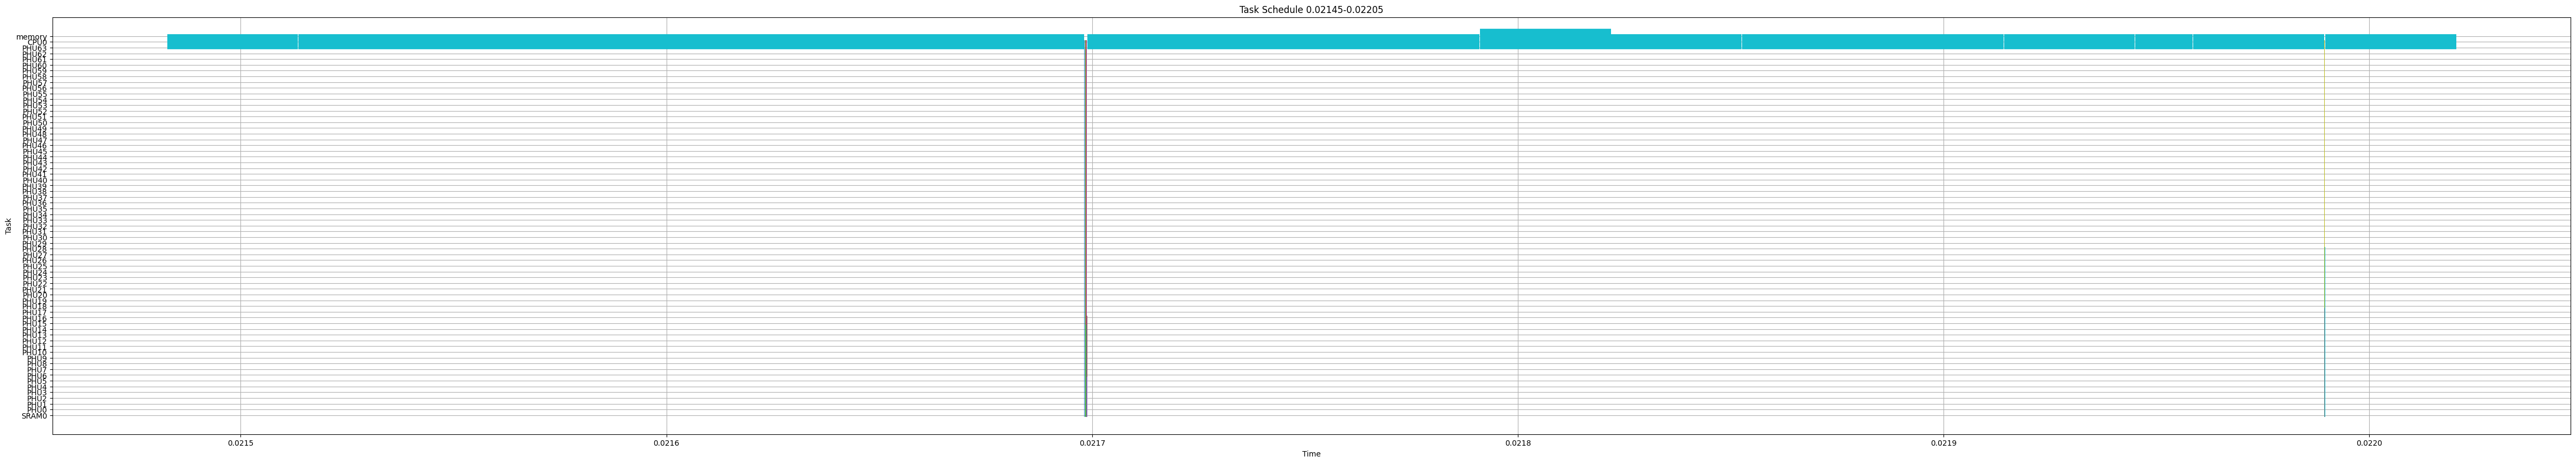

19
0.022051190400000052 - 0.023835510000000056
(30817, 4)


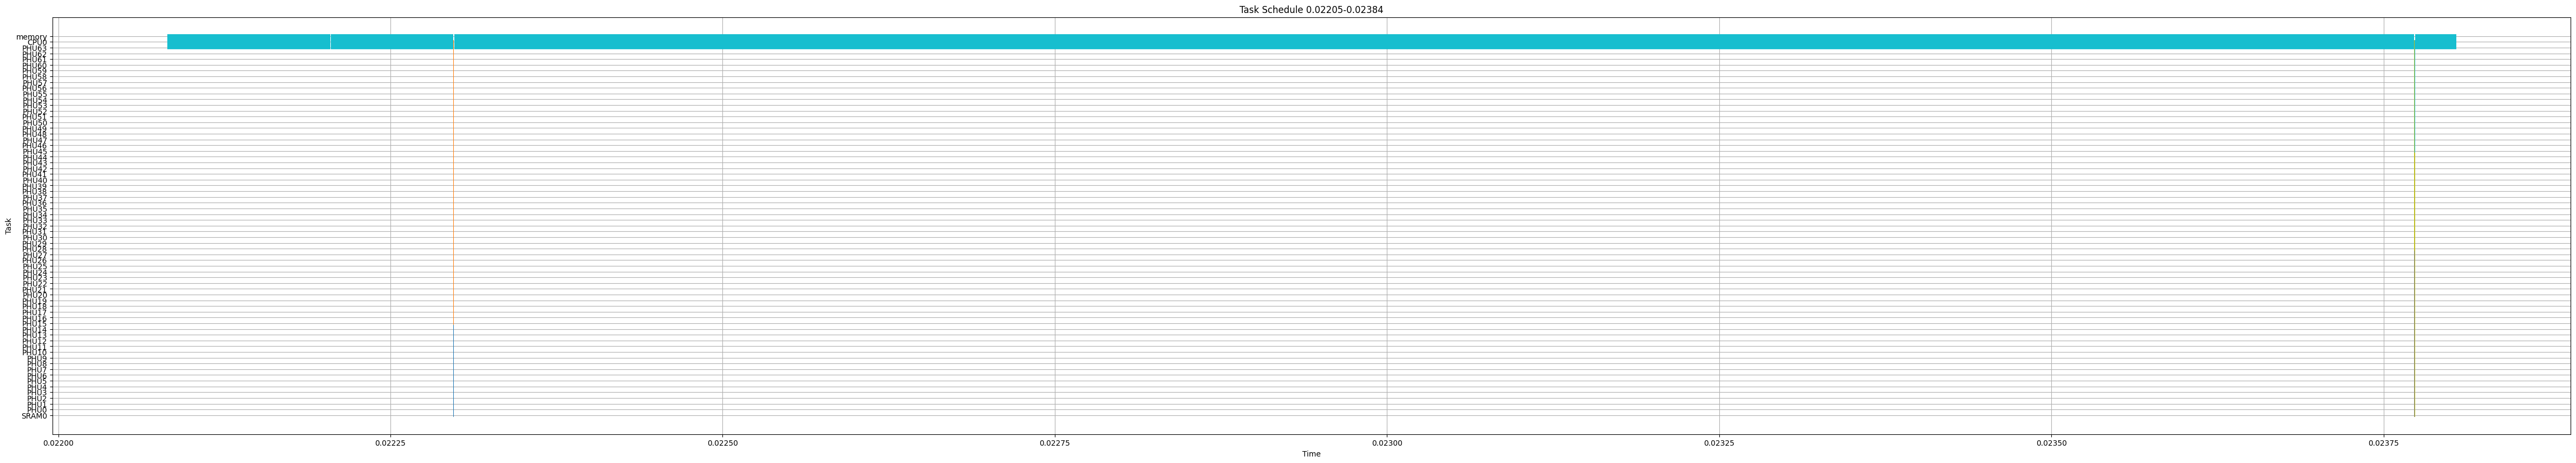

20
0.023835510000000056 - 0.024434722400000088
(30817, 4)


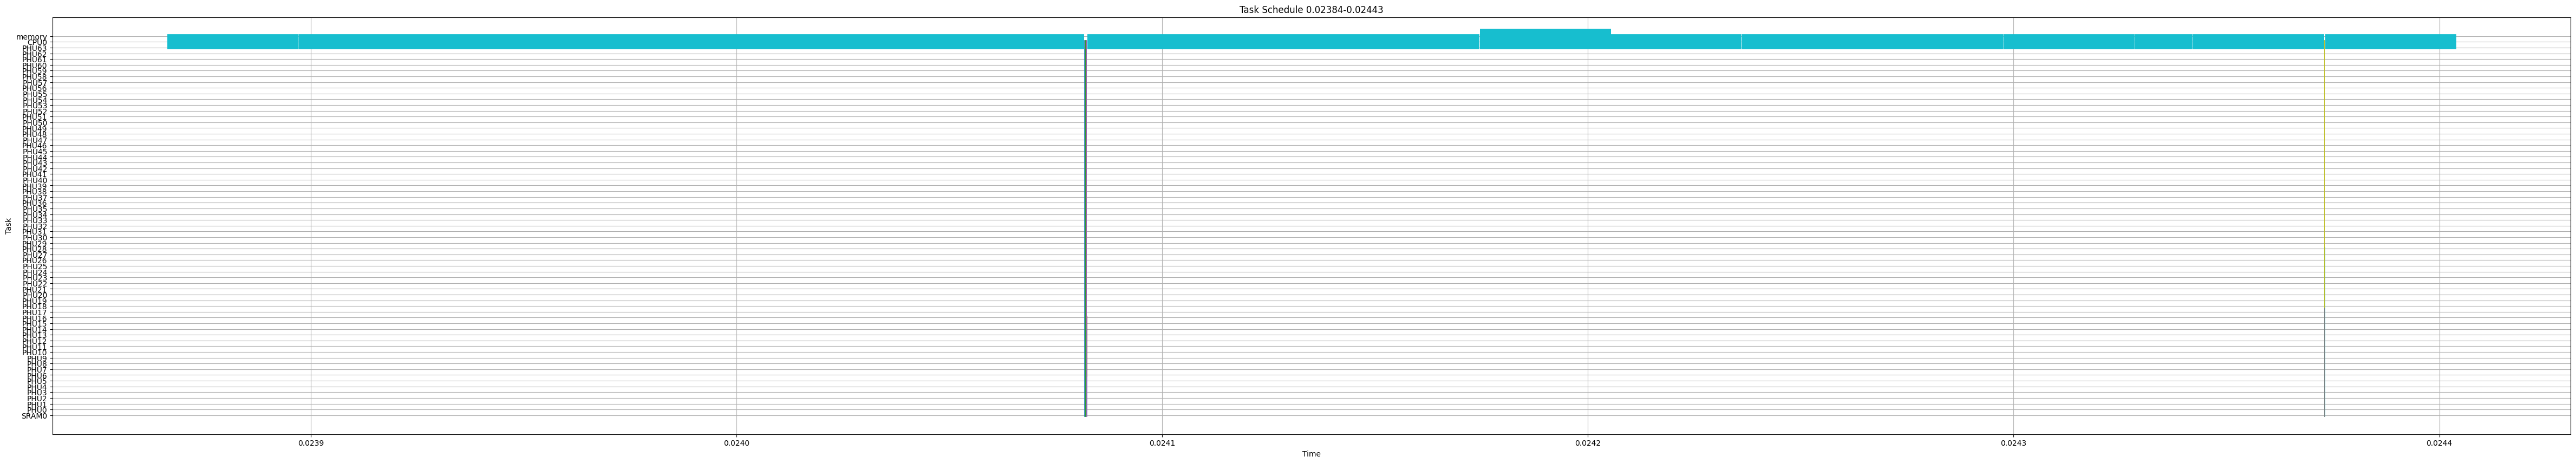

21
0.024434722400000088 - 0.02621904200000009
(30817, 4)


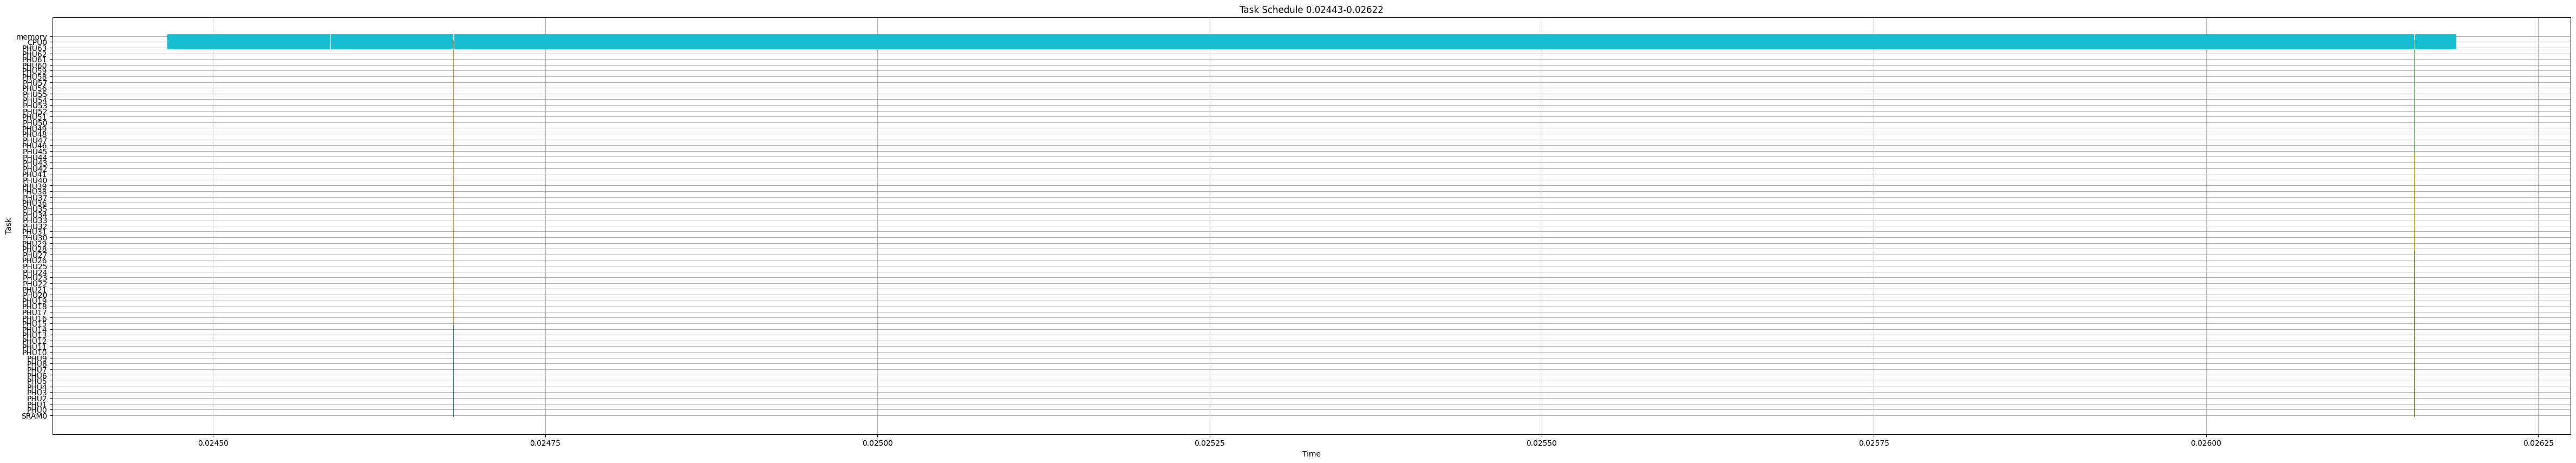

22
0.02621904200000009 - 0.026818254400000123
(30817, 4)


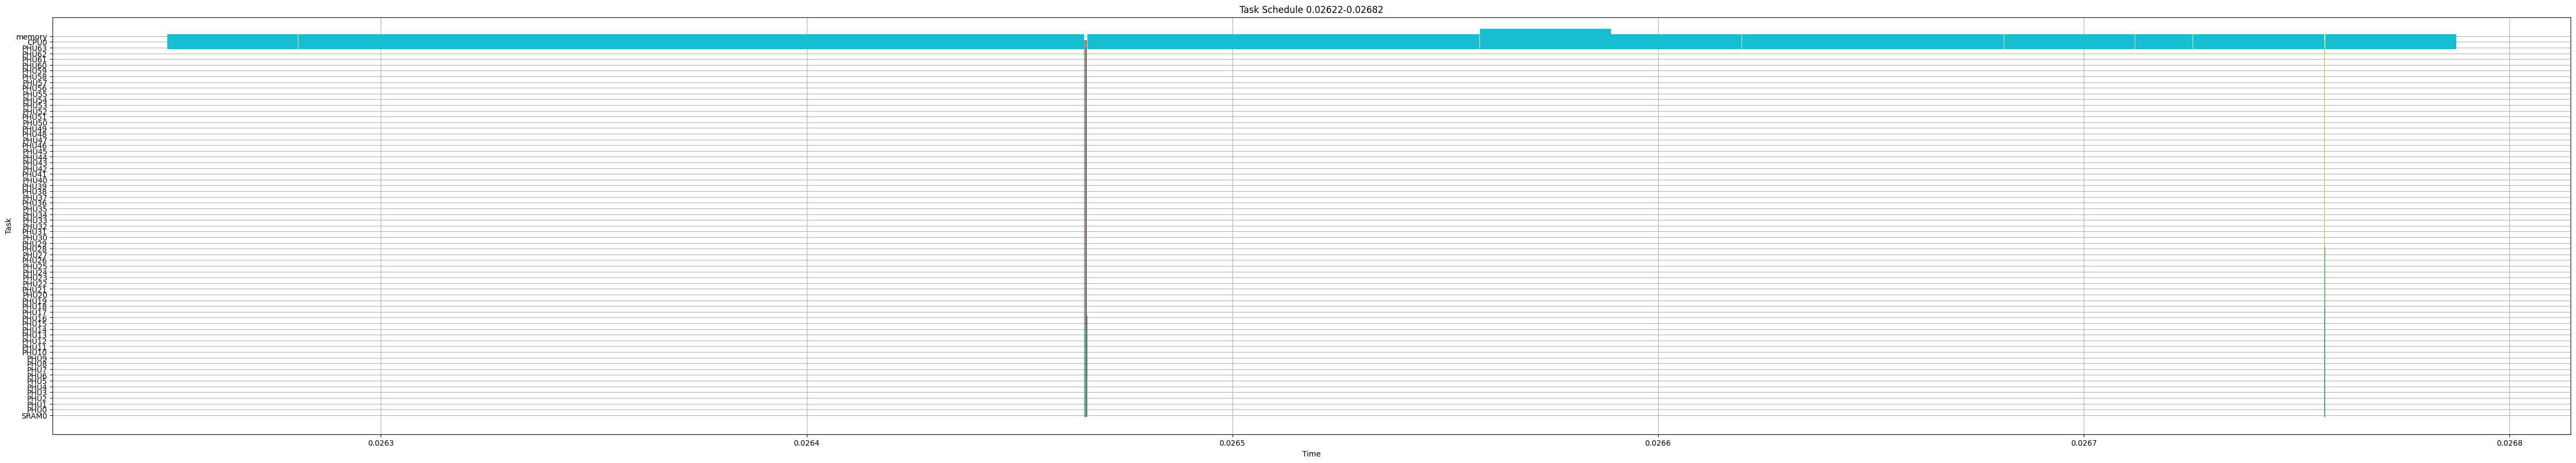

23
0.026818254400000123 - 0.028602574000000127
(30817, 4)


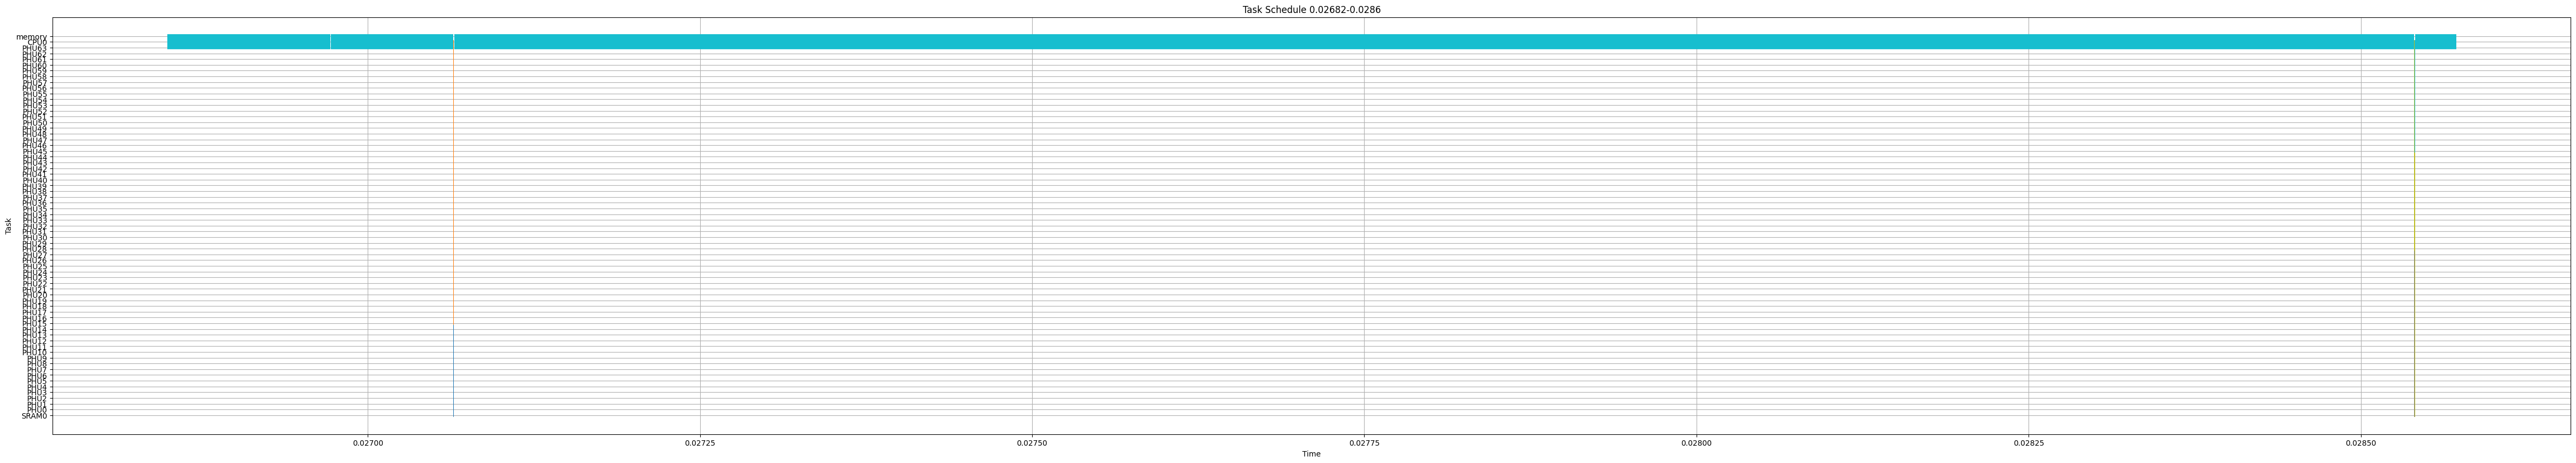

24
0.028602574000000127 - 0.02869481400000013
(30817, 4)


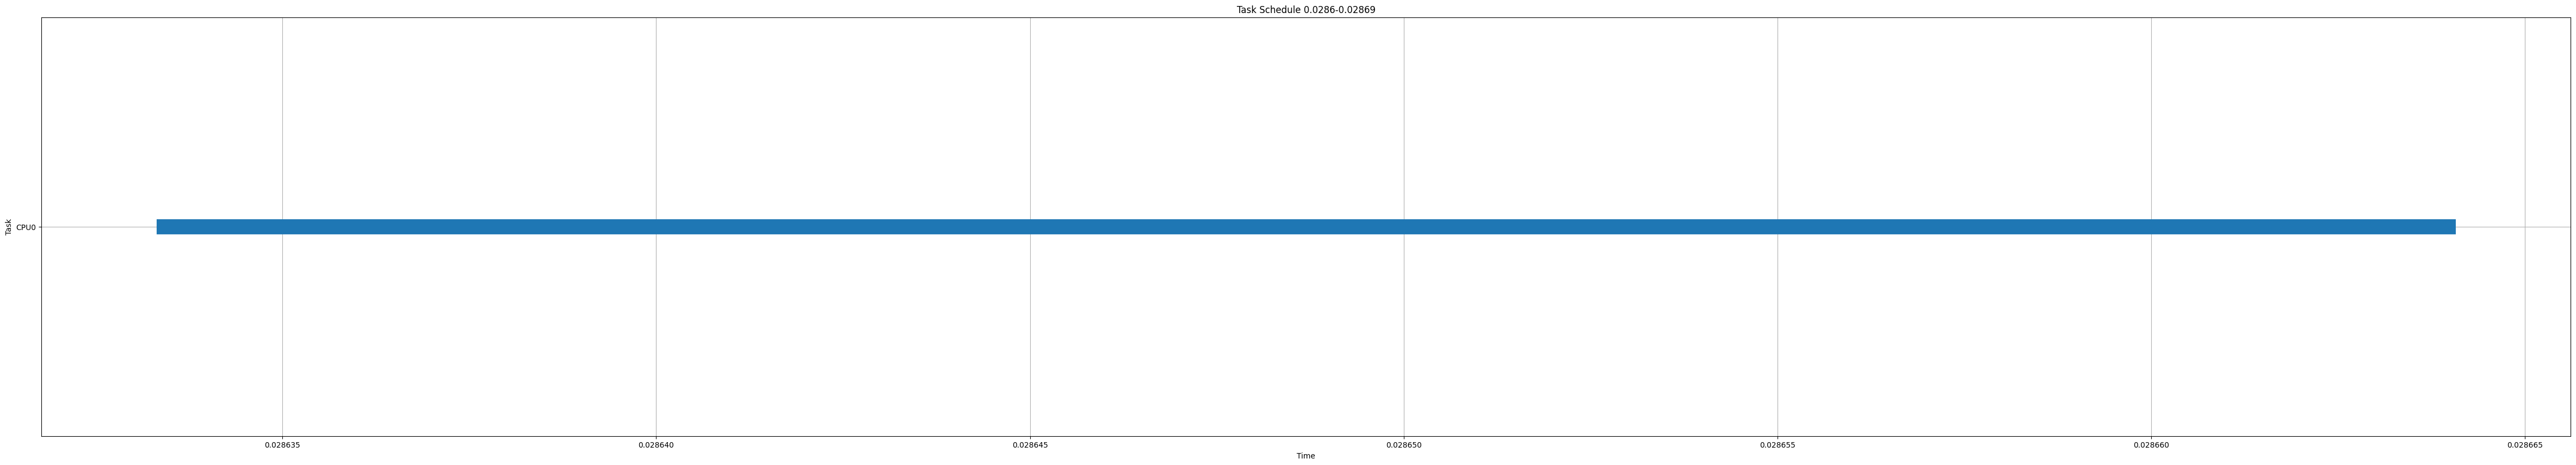

25
0.02869481400000013 - 0.028817914000000135
(30817, 4)


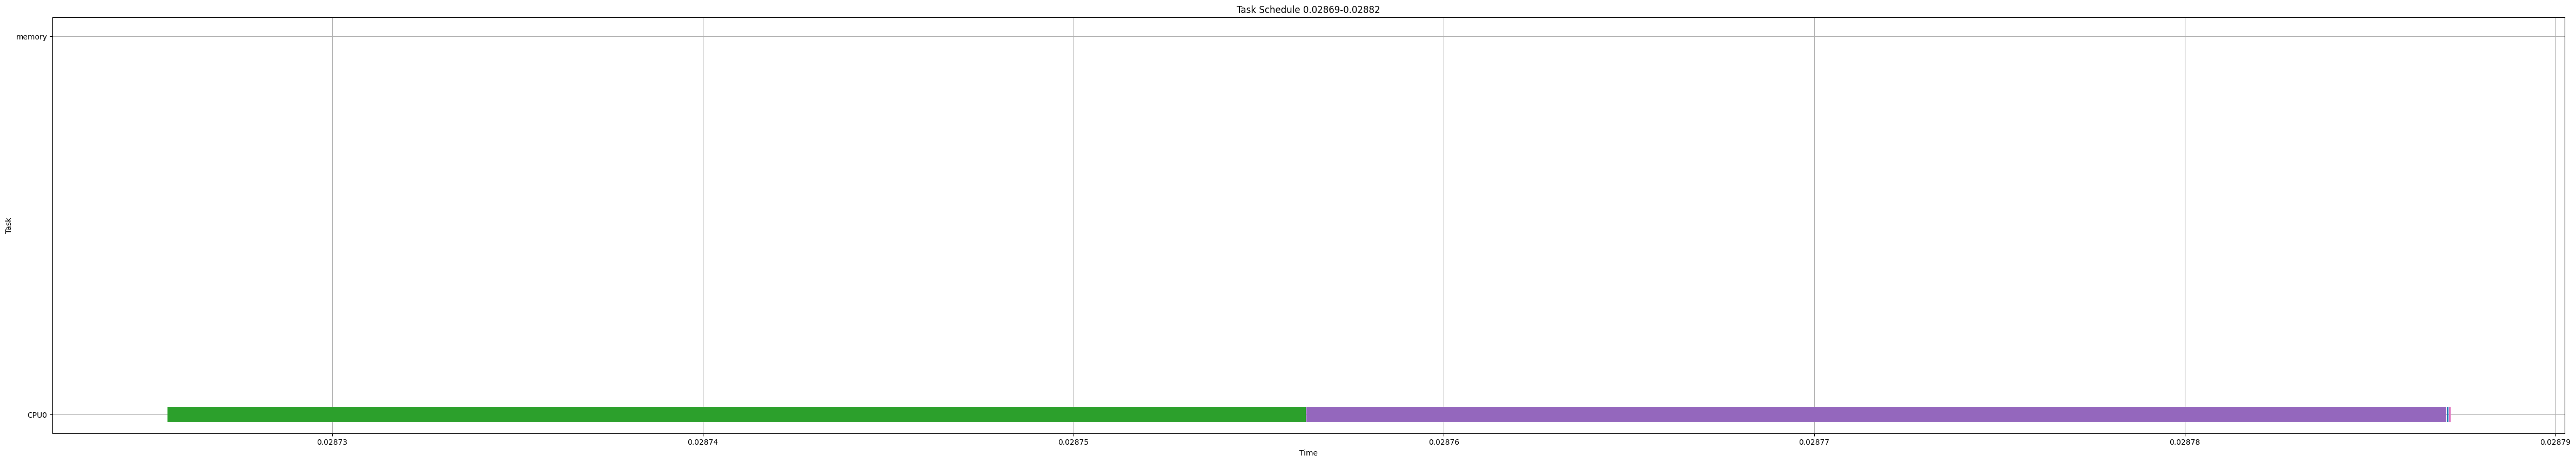

26
0.028817914000000135 - 0.028923898400000158
(30817, 4)


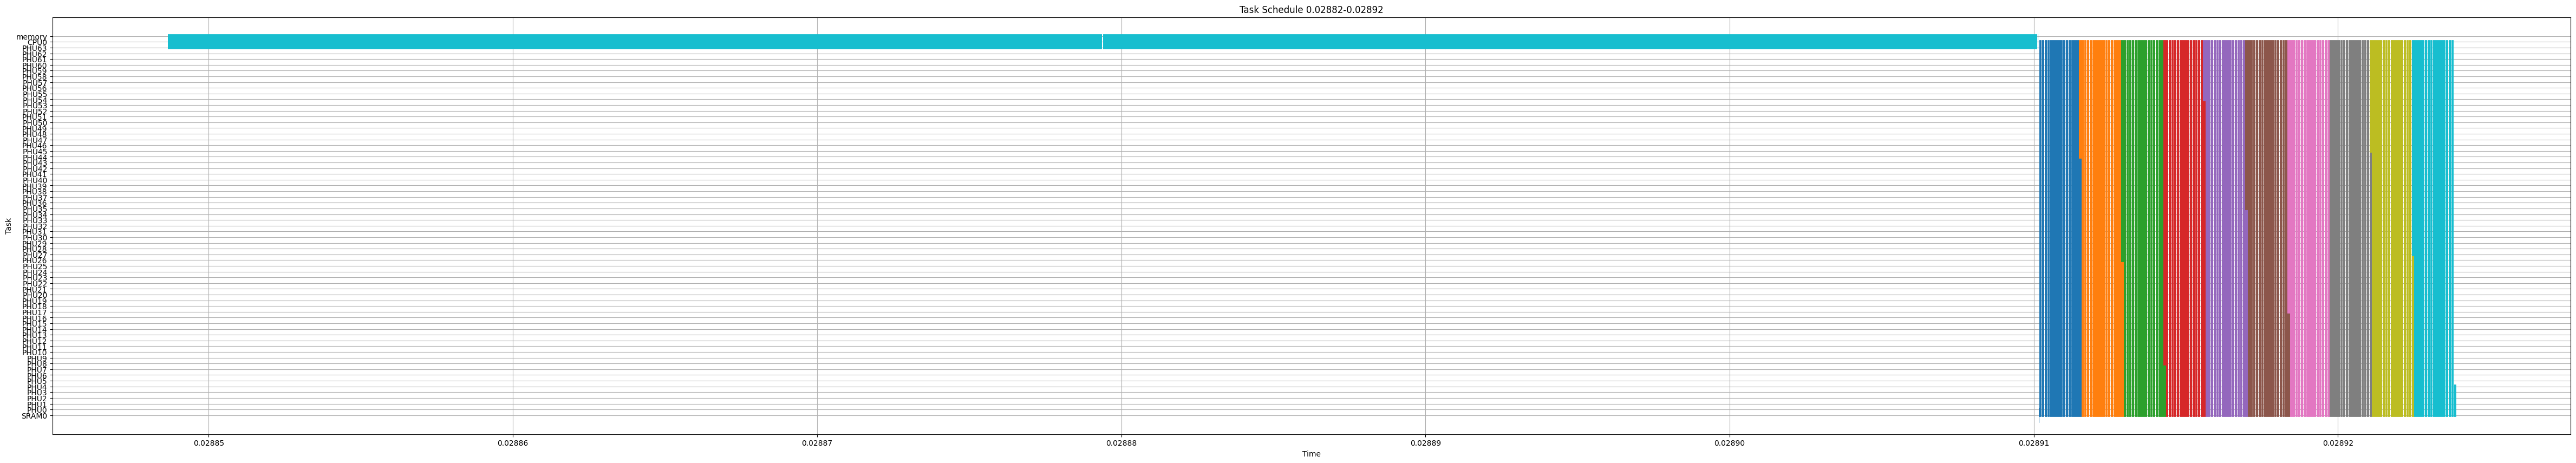

end_time=0.02892


In [9]:
read_json_path = '/home/rjtomich/photonic_compiler/model_to_graph/gpt2_graph.json'
# read_json_path = '/home/rjtomich/photonic_compiler/model_to_graph/bert-base-uncased_graph.json'
# read_json_path = '/home/rjtomich/photonic_compiler/Pytorch-LeNet/simple_LeNet_graph.json'
# read_json_path = '/home/rjtomich/photonic_compiler/Pytorch-LeNet/simple_LeNet_graph_NoFusion.json'
with open(read_json_path)  as json_file:
    raw_json = json.load(json_file) # returns json file as dict

graph = sg.StackGraph(raw_json=raw_json)
stacked_subgraphs = list(dijk.graph_partition(graph))
flat_subgraphs = dijk.select_nodes(stacked_subgraphs)
expanded_flat_subgraphs = dijk.expand_nodes(flat_subgraphs)
scheduled_flat_graph, end_time, break_points = dijk.schdeule_nodes(
    graph, expanded_flat_subgraphs
)
print(end_time)


hardware = set()
for node in scheduled_flat_graph.node_list:
    # if stack.hardware_selection is None:
    #     print(stack)
    hardware.add(node.hardware_selection)
    assert node.hardware_selection is not None
print(hardware)
print(len(scheduled_flat_graph.node_list))

break_points.sort()
gv.make_schedule_diagram(scheduled_flat_graph, xlim_start=None, xlim_end=None)
# gv.make_schedule_diagram(graph, xlim_start=0, xlim_end=0.1)

# # PLOT EACH SUBSECTION
# for i in range(len(break_points)-1):
#     print(i)
#     print(f'{break_points[i]} - {break_points[i+1]}')
#     gv.make_schedule_diagram(scheduled_flat_graph, xlim_start=break_points[i], xlim_end=break_points[i+1])
#     # gv.make_schedule_diagram(scheduled_flat_graph, xlim_start=break_points[i] + 0.00023, xlim_end=break_points[i+1] - 0.00025)


print(f'{end_time=}')
# make_schedule_diagram(graph, xlim_start=0, xlim_end=0.01)


# 4 Memory Visualization

In [10]:
read_json_path = '/home/rjtomich/photonic_compiler/model_to_graph/gpt2_graph.json'
# read_json_path = '/home/rjtomich/photonic_compiler/model_to_graph/bert-base-uncased_graph.json'
# read_json_path = '/home/rjtomich/photonic_compiler/Pytorch-LeNet/simple_LeNet_graph.json'
# read_json_path = '/home/rjtomich/photonic_compiler/Pytorch-LeNet/simple_LeNet_graph_NoFusion.json'
with open(read_json_path)  as json_file:
    raw_json = json.load(json_file) # returns json file as dict


graph = sg.StackedGraph(raw_json=raw_json)
# gv.adj_to_graph(graph.adj_matrix, save=True, layout = 'spectral')
subgraphs = list(dijk.graph_partition(graph))

dijk.select_nodes(graph, subgraphs)
end_time, break_points = dijk.schdeule_nodes(graph, subgraphs)
break_points.sort()
print(f'{end_time=}')
schedule_data = graph.create_schedule_data()
dram, sram = dijk.get_memory_profile(graph)

AttributeError: module 'stacked_graph' has no attribute 'StackedGraph'

In [ ]:
dram_t, dram_v = zip(*dram)
sram_t, sram_v = zip(*sram)

sram_v = [-v for v in sram_v]


plt.figure(figsize=(30, 5))  # Optional: Adjust figure size

plt.plot(dram_t, dram_v, linestyle='-', color='b', label='DRAM')
plt.plot(sram_t, sram_v, linestyle='--', color='r', label='SRAM')

plt.xlabel('Time')
plt.ylabel('Bits')
plt.title('Memory')
plt.legend()


plt.grid(True)
plt.tight_layout()

plt.show()

NameError: name 'dram' is not defined